In [57]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import HypergraphConv, global_mean_pool, BatchNorm
import uproot
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt


In [58]:

# Configuration
jet_features = ['Jet.PT', 'Jet.Phi', 'Jet.Mass', 'Jet.NCharged', 'Jet.EhadOverEem',
                'Jet.Eta', 'Jet.BTag', 'Jet.Flavor', 'Jet.T', 'Jet.DeltaEta',
                'Jet.DeltaPhi', 'Jet.ChargedEnergyFraction', 'Jet.NeutralEnergyFraction']
lepton_features = ['Electron.PT', 'Electron.Eta', 'Electron.Phi', 'Muon.PT', 'Muon.Eta', 'Muon.Phi']
met_features = ['MissingET.MET', 'MissingET.Phi']
all_features = jet_features + lepton_features + met_features

signal_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_signal_5k.root'
background_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_BKG_5k.root'

# signal_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_signal.root'
# background_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_BKG.root'
tree_name = 'Delphes'
batch_size = 8
delta_r_threshold = 1
hidden_dim = 512


# Helper functions
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(delta_eta**2 + delta_phi**2)

def normalize_features(x):
    if x.shape[0] == 0:
        return x
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)

# Data loading function for hypergraphs using Data
def load_data_hypergraph(file_path, label):
    file = uproot.open(file_path)
    tree = file[tree_name]
    data_list = []

    events = tree.arrays(all_features, library='np')
    num_events = len(events[jet_features[0]])

    for i in range(num_events):
        # Process jet nodes
        jet_data = [events[feat][i] for feat in jet_features]
        x_jets = np.column_stack(jet_data)
        x_jets = np.nan_to_num(x_jets)
        x_jets = normalize_features(x_jets)

        # Process lepton nodes (combine electrons and muons)
        elec_data = [events[feat][i] for feat in lepton_features[:3]]
        muon_data = [events[feat][i] for feat in lepton_features[3:]]
        if len(elec_data[0]) == 0 and len(muon_data[0]) == 0:
            x_leptons = np.zeros((0, 3))
        else:
            x_elec = np.column_stack(elec_data) if len(elec_data[0]) > 0 else np.empty((0, 3))
            x_muon = np.column_stack(muon_data) if len(muon_data[0]) > 0 else np.empty((0, 3))
            x_leptons = np.vstack([x_elec, x_muon])
        # Pad to 13 features to match jets
        if x_leptons.size == 0:
            x_leptons = np.zeros((0, 13))
        elif x_leptons.shape[1] != 13:
            x_leptons = np.pad(x_leptons, ((0, 0), (0, 13 - x_leptons.shape[1])), mode='constant')
        x_leptons = normalize_features(x_leptons)

        # Process MET nodes
        met_data = [events[feat][i] for feat in met_features]
        x_met = np.array(met_data).reshape(1, -1)
        x_met = np.nan_to_num(x_met)
        if x_met.shape[1] != 13:
            x_met = np.pad(x_met, ((0, 0), (0, 13 - x_met.shape[1])), mode='constant')
        x_met = normalize_features(x_met)

        # Combine all nodes into a single tensor
        num_jets, num_leptons, num_met = x_jets.shape[0], x_leptons.shape[0], x_met.shape[0]
        if num_jets + num_leptons + num_met == 0:
            continue
        x_all = np.vstack([x_jets, x_leptons, x_met])

        # Store eta and phi for hyperedge creation
        eta_all = np.concatenate([
            x_jets[:, 5] if num_jets > 0 else np.array([]),
            x_leptons[:, 1] if num_leptons > 0 else np.array([]),
            x_met[:, 1] if num_met > 0 else np.array([])  # Assuming MET has phi at index 1
        ])
        phi_all = np.concatenate([
            x_jets[:, 1] if num_jets > 0 else np.array([]),
            x_leptons[:, 2] if num_leptons > 0 else np.array([]),
            x_met[:, 0] if num_met > 0 else np.array([])  # Assuming MET has phi at index 0
        ])

        # Create hyperedges based on delta_r_threshold
        hyperedge_list = []
        num_nodes = len(eta_all)
        for j in range(num_nodes):
            neighbors = [j]  # Include the node itself
            for k in range(num_nodes):
                if j != k and delta_r(eta_all[j], phi_all[j], eta_all[k], phi_all[k]) < delta_r_threshold:
                    neighbors.append(k)
            if len(neighbors) > 1:  # Only add hyperedges with more than one node
                hyperedge_list.append(neighbors)

        # Construct hyperedge_index correctly
        if not hyperedge_list:
            hyperedge_index = torch.empty((2, 0), dtype=torch.long)
        else:
            hyperedge_sizes = [len(h) for h in hyperedge_list]
            node_indices = np.concatenate(hyperedge_list)
            hyperedge_indices = np.repeat(np.arange(len(hyperedge_list)), hyperedge_sizes)
            hyperedge_index = torch.tensor([node_indices, hyperedge_indices], dtype=torch.long)

        # Create Data object for hypergraph
        data = Data()
        data.x = torch.tensor(x_all, dtype=torch.float)
        data.hyperedge_index = hyperedge_index
        data.y = torch.tensor([label], dtype=torch.float)
        data.num_nodes = num_nodes
        data_list.append(data)

    return data_list


In [59]:

# Load and split data for hypergraphs
signal_data = load_data_hypergraph(signal_file, label=1)
background_data = load_data_hypergraph(background_file, label=0)
dataset = signal_data + background_data
np.random.shuffle(dataset)
split = int(0.8 * len(dataset))
train_data = dataset[:split]
test_data = dataset[split:]
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Define the hypergraph model
class HypergraphEventClassifier(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.conv1 = HypergraphConv(in_channels=13, out_channels=hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)
        self.conv2 = HypergraphConv(in_channels=hidden_dim, out_channels=hidden_dim // 2)
        self.bn2 = BatchNorm(hidden_dim // 2)
        self.fc = torch.nn.Linear(hidden_dim // 2, 1)

    def forward(self, data):
        x, hyperedge_index = data.x, data.hyperedge_index
        x = self.conv1(x, hyperedge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv2(x, hyperedge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        # Global pooling over all nodes in each graph
        x = global_mean_pool(x, data.batch)
        return self.fc(x).squeeze(-1)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HypergraphEventClassifier(hidden_dim).to(device)
labels = [data.y.item() for data in dataset]
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-7)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.6, patience=10)

# Training and evaluation functions
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_data)

def test(loader):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item() * data.num_graphs
            pred = torch.sigmoid(out)
            y_true.extend(data.y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
            pred_class = (pred > 0.5).float()
            correct += (pred_class == data.y).sum().item()
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    acc = correct / len(y_true)
    roc_auc = roc_auc_score(y_true, y_pred)
    avg_loss = total_loss / len(loader.dataset)
    return acc, roc_auc, avg_loss, y_true, y_pred

# Training loop
train_losses, val_losses, val_accs, val_rocs = [], [], [], []
best_roc_auc = 0
patience, early_stop_counter = 80, 0

for epoch in range(1, 101):  # Adjust epochs as needed
    loss = train()
    val_acc, val_roc_auc, val_loss, y_true, y_pred = test(test_loader)

    train_losses.append(loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_rocs.append(val_roc_auc)

    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Val Acc: {val_acc:.4f}, Val ROC-AUC: {val_roc_auc:.4f}')

    scheduler.step(val_roc_auc)
    if val_roc_auc > best_roc_auc:
        best_roc_auc = val_roc_auc
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break


c:\ProgramData\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 01, Loss: 0.6620, Val Loss: 0.6377, Val Acc: 0.6390, Val ROC-AUC: 0.6974
Epoch: 02, Loss: 0.6397, Val Loss: 0.6314, Val Acc: 0.6450, Val ROC-AUC: 0.7064
Epoch: 03, Loss: 0.6274, Val Loss: 0.6206, Val Acc: 0.6485, Val ROC-AUC: 0.7210
Epoch: 04, Loss: 0.6171, Val Loss: 0.6138, Val Acc: 0.6615, Val ROC-AUC: 0.7241
Epoch: 05, Loss: 0.6111, Val Loss: 0.6103, Val Acc: 0.6655, Val ROC-AUC: 0.7293
Epoch: 06, Loss: 0.6128, Val Loss: 0.6066, Val Acc: 0.6710, Val ROC-AUC: 0.7319
Epoch: 07, Loss: 0.6099, Val Loss: 0.6073, Val Acc: 0.6685, Val ROC-AUC: 0.7324
Epoch: 08, Loss: 0.6062, Val Loss: 0.6041, Val Acc: 0.6765, Val ROC-AUC: 0.7350
Epoch: 09, Loss: 0.6037, Val Loss: 0.6018, Val Acc: 0.6825, Val ROC-AUC: 0.7385


KeyboardInterrupt: 

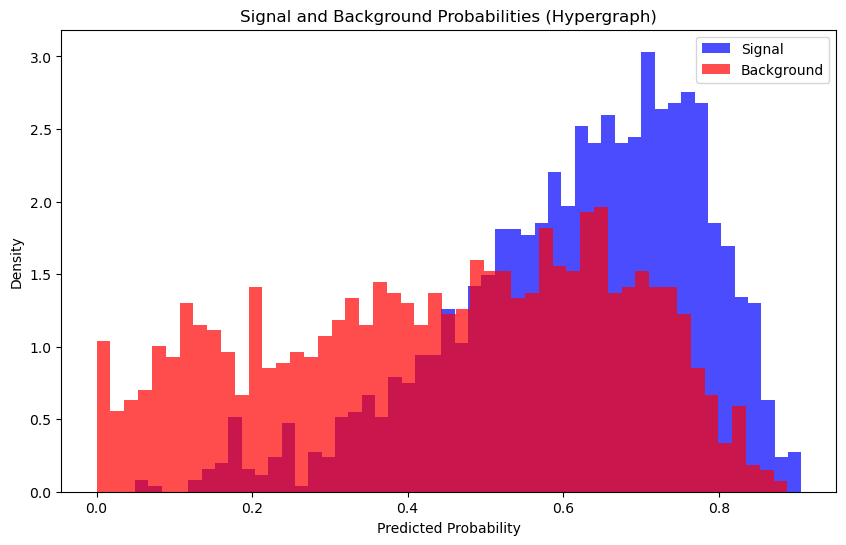

Signal Count: 1166
Background Count: 689
Significance: 27.072389730392953
Accuracy: 0.6650
Precision: 0.6286
Recall: 0.7868
F1 Score: 0.6988


In [ ]:

# Post-training analysis
y_pred_class = (y_pred > 0.5).astype(int)

# Plot signal vs background probabilities
signal_probs = y_pred[y_true == 1]
background_probs = y_pred[y_true == 0]
plt.figure(figsize=(10, 6))
plt.hist(signal_probs, bins=50, alpha=0.7, label='Signal', color='blue', density=True)
plt.hist(background_probs, bins=50, alpha=0.7, label='Background', color='red', density=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Signal and Background Probabilities (Hypergraph)')
plt.legend()
plt.show()

# Calculate significance
signal_count = np.sum((y_pred_class == 1) & (y_true == 1))
background_count = np.sum((y_pred_class == 1) & (y_true == 0))
significance = signal_count / np.sqrt(signal_count + background_count) if signal_count + background_count > 0 else 0
print(f"Signal Count: {signal_count}")
print(f"Background Count: {background_count}")
print(f"Significance: {significance}")

# Calculate additional metrics
accuracy = accuracy_score(y_true, y_pred_class)
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

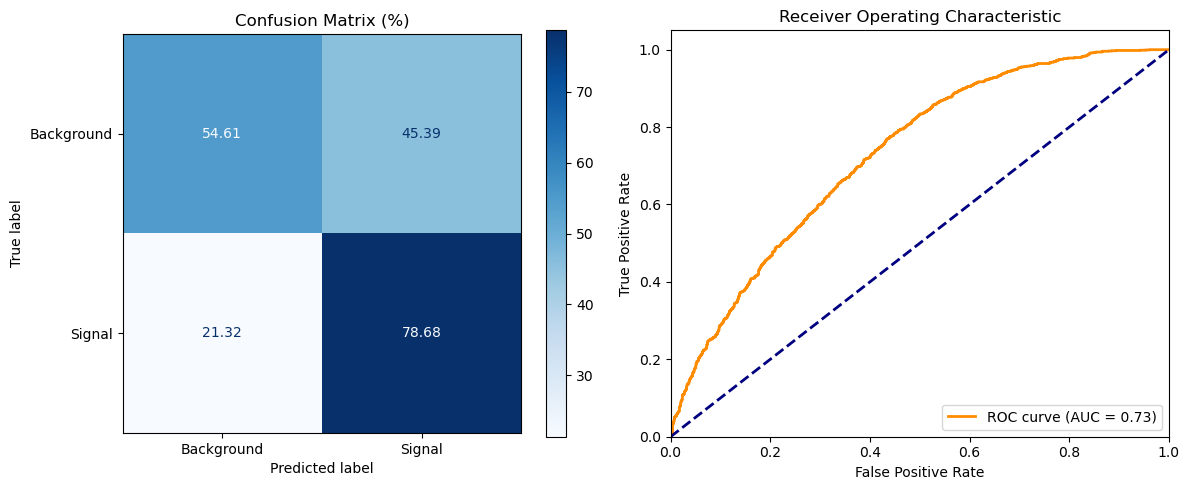

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_class)
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix with percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=["Background", "Signal"])
disp.plot(ax=ax[0], cmap='Blues', values_format=".2f")
ax[0].set_title("Confusion Matrix (%)")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

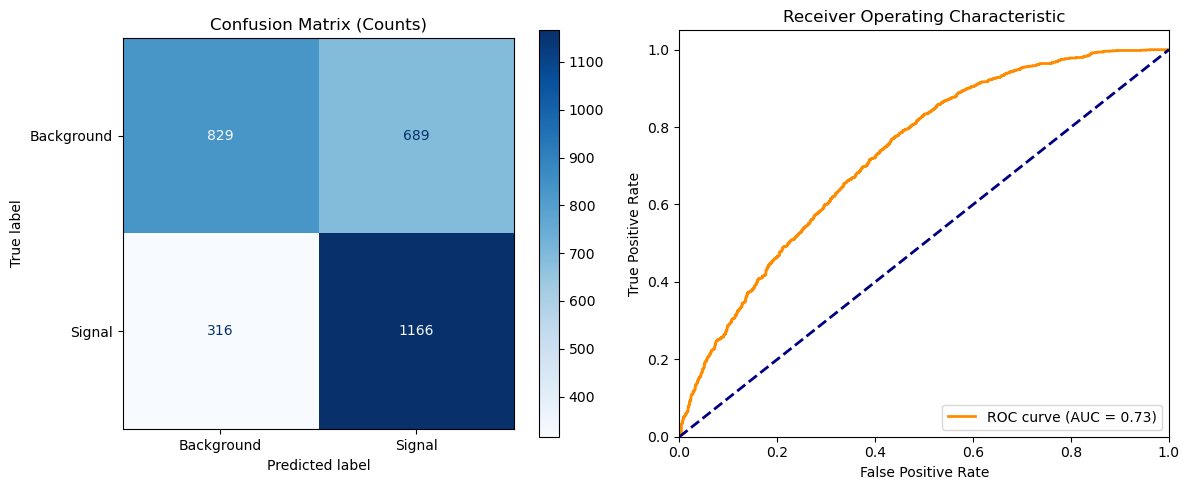

In [ ]:
# Plot confusion matrix with raw numbers
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Raw confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Signal"])
disp.plot(ax=ax[0], cmap='Blues', values_format="d")
ax[0].set_title("Confusion Matrix (Counts)")

# ROC curve (keep as before)
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

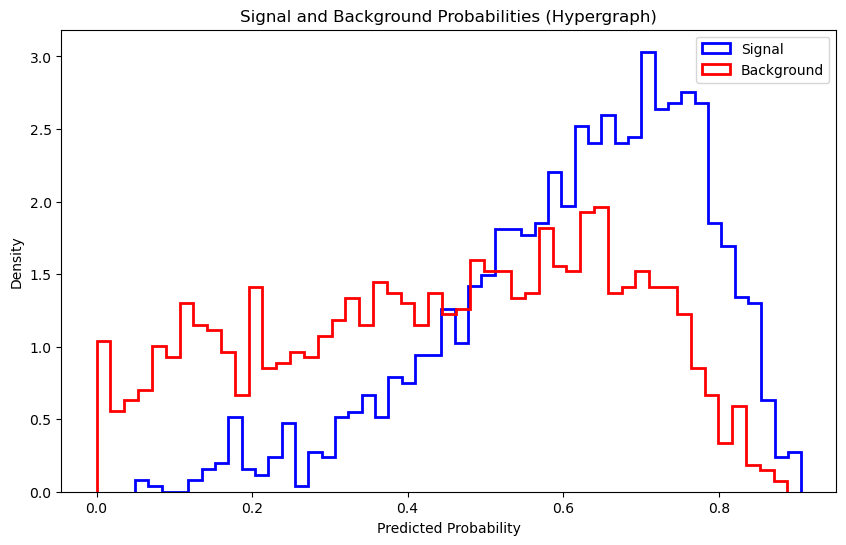

In [ ]:
# Plot signal vs background probabilities with solid lines (no fill)
plt.figure(figsize=(10, 6))
plt.hist(signal_probs, bins=50, density=True, histtype='step', label='Signal', color='blue', linewidth=2)
plt.hist(background_probs, bins=50, density=True, histtype='step', label='Background', color='red', linewidth=2)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Signal and Background Probabilities (Hypergraph)')
plt.legend()
plt.show()

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import HypergraphConv, global_mean_pool, BatchNorm
import uproot
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Configuration
jet_features = ['Jet.PT', 'Jet.Phi', 'Jet.Mass', 'Jet.NCharged', 'Jet.EhadOverEem',
                'Jet.Eta', 'Jet.BTag', 'Jet.Flavor', 'Jet.T', 'Jet.DeltaEta',
                'Jet.DeltaPhi', 'Jet.ChargedEnergyFraction', 'Jet.NeutralEnergyFraction']
lepton_features = ['Electron.PT', 'Electron.Eta', 'Electron.Phi', 'Muon.PT', 'Muon.Eta', 'Muon.Phi']
met_features = ['MissingET.MET', 'MissingET.Phi']
all_features = jet_features + lepton_features + met_features

signal_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_signal_5k.root'
background_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_BKG_5k.root'
tree_name = 'Delphes'
batch_size = 32
delta_r_threshold = 2

# Helper functions
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(delta_eta**2 + delta_phi**2)

def normalize_features(x):
    if x.shape[0] == 0:
        return x
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)

def convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_thresh=2.0):
    N = x_all.shape[0]
    if N == 0:
        return None

    edge_index_list = []
    edge_attr_list = []
    edge_target_list = []
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            dr = delta_r(eta_all[i], phi_all[i], eta_all[j], phi_all[j])
            if dr < delta_r_thresh:
                edge_index_list.append([i, j])
                edge_attr_list.append([dr])
                edge_target_list.append([1])
            else:
                edge_index_list.append([i, j])
                edge_attr_list.append([dr])
                edge_target_list.append([0])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).T
    edge_attr_s = torch.tensor(edge_attr_list, dtype=torch.float)
    edge_attr_t = torch.tensor(edge_target_list, dtype=torch.float)

    hyperedge_list = []
    for j in range(N):
        neighbors = [j]
        for k in range(N):
            if j != k and delta_r(eta_all[j], phi_all[j], eta_all[k], phi_all[k]) < delta_r_thresh:
                neighbors.append(k)
        if len(neighbors) > 1:
            hyperedge_list.append(neighbors)

    if not hyperedge_list:
        return None

    node_indices = np.concatenate(hyperedge_list)
    hyperedge_indices = np.repeat(np.arange(len(hyperedge_list)), [len(h) for h in hyperedge_list])
    hyperedge_index = torch.tensor([node_indices, hyperedge_indices], dtype=torch.long)

    u_s = torch.tensor([[x_all[:, 0].sum(), x_all[:, 1].mean()]], dtype=torch.float)

    data = Data(
        x_s=torch.tensor(x_all, dtype=torch.float),
        u_s=u_s,
        edge_index=edge_index,
        edge_attr_s=edge_attr_s,
        edge_attr_s_batch=torch.zeros(edge_index.shape[1], dtype=torch.long),
        edge_attr_t=edge_attr_t,
        edge_index_h=hyperedge_index,
        edge_index_h_batch=torch.zeros(hyperedge_index.shape[1], dtype=torch.long),
        x_t=torch.tensor([label], dtype=torch.float),
        batch=torch.zeros(N, dtype=torch.long)
    )
    return data

def load_data_hyper_format(file_path, label):
    file = uproot.open(file_path)
    tree = file[tree_name]
    events = tree.arrays(all_features, library='np')
    data_list = []

    num_events = len(events[jet_features[0]])
    for i in range(num_events):
        jet_data = [events[feat][i] for feat in jet_features]
        x_jets = np.column_stack(jet_data)
        x_jets = np.nan_to_num(x_jets)
        x_jets = normalize_features(x_jets)

        elec_data = [events[feat][i] for feat in lepton_features[:3]]
        muon_data = [events[feat][i] for feat in lepton_features[3:]]
        x_elec = np.column_stack(elec_data) if len(elec_data[0]) > 0 else np.empty((0, 3))
        x_muon = np.column_stack(muon_data) if len(muon_data[0]) > 0 else np.empty((0, 3))
        x_leptons = np.vstack([x_elec, x_muon])

        if x_leptons.size == 0:
            x_leptons = np.zeros((0, 13))
        elif x_leptons.shape[1] != 13:
            x_leptons = np.pad(x_leptons, ((0, 0), (0, 13 - x_leptons.shape[1])), mode='constant')
        x_leptons = normalize_features(x_leptons)

        met_data = [events[feat][i] for feat in met_features]
        x_met = np.array(met_data).reshape(1, -1)
        x_met = np.nan_to_num(x_met)
        if x_met.shape[1] != 13:
            x_met = np.pad(x_met, ((0, 0), (0, 13 - x_met.shape[1])), mode='constant')
        x_met = normalize_features(x_met)

        x_all = np.vstack([x_jets, x_leptons, x_met])
        eta_all = np.concatenate([
            x_jets[:, 5] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 1] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 1] if x_met.shape[0] > 0 else np.array([])
        ])
        phi_all = np.concatenate([
            x_jets[:, 1] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 2] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 0] if x_met.shape[0] > 0 else np.array([])
        ])

        data = convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_threshold)
        if data:
            data_list.append(data)

    return data_list

# Load full dataset
signal_data = load_data_hyper_format(signal_file, 1)
background_data = load_data_hyper_format(background_file, 0)
dataset = signal_data + background_data
np.random.shuffle(dataset)
split = int(0.8 * len(dataset))
train_data = dataset[:split]
test_data = dataset[split:]
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Print a sample batch to verify
print(train_data[0])


C:\Users\sande\AppData\Local\Temp\ipykernel_7448\1548408519.py:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  hyperedge_index = torch.tensor([node_indices, hyperedge_indices], dtype=torch.long)


Data(edge_index=[2, 56], x_s=[8, 13], u_s=[1, 2], edge_attr_s=[56, 1], edge_attr_s_batch=[56], edge_attr_t=[56, 1], edge_index_h=[2, 46], edge_index_h_batch=[46], x_t=[1], batch=[8])


c:\ProgramData\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [4]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import uproot
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from HyPER.models import MPNNs, HyperedgeModel, HyperedgeLoss, EdgeLoss, CombinedLoss
from HyPER.evaluation import Accuracy
from torchmetrics.classification import BinaryAccuracy

# Configuration
jet_features = ['Jet.PT', 'Jet.Phi', 'Jet.Mass', 'Jet.NCharged', 'Jet.EhadOverEem',
                'Jet.Eta', 'Jet.BTag', 'Jet.Flavor', 'Jet.T', 'Jet.DeltaEta',
                'Jet.DeltaPhi', 'Jet.ChargedEnergyFraction', 'Jet.NeutralEnergyFraction']
lepton_features = ['Electron.PT', 'Electron.Eta', 'Electron.Phi', 'Muon.PT', 'Muon.Eta', 'Muon.Phi']
met_features = ['MissingET.MET', 'MissingET.Phi']
all_features = jet_features + lepton_features + met_features

signal_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_signal_5k.root'
background_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_BKG_5k.root'
tree_name = 'Delphes'
batch_size = 32
delta_r_threshold = 2

# Helper functions
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(delta_eta**2 + delta_phi**2)

def normalize_features(x):
    if x.shape[0] == 0:
        return x
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)

def convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_thresh=2.0):
    N = x_all.shape[0]
    if N == 0:
        return None

    edge_index_list = []
    edge_attr_list = []
    edge_target_list = []
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            dr = delta_r(eta_all[i], phi_all[i], eta_all[j], phi_all[j])
            edge_index_list.append([i, j])
            edge_attr_list.append([dr])
            edge_target_list.append([1 if dr < delta_r_thresh else 0])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).T
    edge_attr_s = torch.tensor(edge_attr_list, dtype=torch.float)
    edge_attr_t = torch.tensor(edge_target_list, dtype=torch.float)

    hyperedge_list = []
    for j in range(N):
        neighbors = [j]
        for k in range(N):
            if j != k and delta_r(eta_all[j], phi_all[j], eta_all[k], phi_all[k]) < delta_r_thresh:
                neighbors.append(k)
        if len(neighbors) > 1:
            hyperedge_list.append(neighbors)

    if not hyperedge_list:
        return None

    node_indices = np.concatenate(hyperedge_list).astype(np.int64)
    hyperedge_indices = np.repeat(np.arange(len(hyperedge_list)), [len(h) for h in hyperedge_list]).astype(np.int64)
    hyperedge_index = torch.from_numpy(np.stack([node_indices, hyperedge_indices])).long()

    u_s = torch.tensor([[x_all[:, 0].sum(), x_all[:, 1].mean()]], dtype=torch.float)

    data = Data(
        x_s=torch.tensor(x_all, dtype=torch.float),
        u_s=u_s,
        edge_index=edge_index,
        edge_attr_s=edge_attr_s,
        edge_attr_s_batch=torch.zeros(edge_index.shape[1], dtype=torch.long),
        edge_attr_t=edge_attr_t.view(-1, 1),
        edge_index_h=hyperedge_index,
        edge_index_h_batch=torch.zeros(hyperedge_index.shape[1], dtype=torch.long),
        x_t=torch.tensor([label], dtype=torch.float),
        batch=torch.zeros(N, dtype=torch.long)
    )
    return data

def load_data_hyper_format(file_path, label):
    file = uproot.open(file_path)
    tree = file[tree_name]
    events = tree.arrays(all_features, library='np')
    data_list = []

    num_events = len(events[jet_features[0]])
    for i in range(num_events):
        jet_data = [events[feat][i] for feat in jet_features]
        x_jets = np.column_stack(jet_data)
        x_jets = np.nan_to_num(x_jets)
        x_jets = normalize_features(x_jets)

        elec_data = [events[feat][i] for feat in lepton_features[:3]]
        muon_data = [events[feat][i] for feat in lepton_features[3:]]
        x_elec = np.column_stack(elec_data) if len(elec_data[0]) > 0 else np.empty((0, 3))
        x_muon = np.column_stack(muon_data) if len(muon_data[0]) > 0 else np.empty((0, 3))
        x_leptons = np.vstack([x_elec, x_muon])

        if x_leptons.size == 0:
            x_leptons = np.zeros((0, 13))
        elif x_leptons.shape[1] != 13:
            x_leptons = np.pad(x_leptons, ((0, 0), (0, 13 - x_leptons.shape[1])), mode='constant')
        x_leptons = normalize_features(x_leptons)

        met_data = [events[feat][i] for feat in met_features]
        x_met = np.array(met_data).reshape(1, -1)
        x_met = np.nan_to_num(x_met)
        if x_met.shape[1] != 13:
            x_met = np.pad(x_met, ((0, 0), (0, 13 - x_met.shape[1])), mode='constant')
        x_met = normalize_features(x_met)

        x_all = np.vstack([x_jets, x_leptons, x_met])
        eta_all = np.concatenate([
            x_jets[:, 5] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 1] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 1] if x_met.shape[0] > 0 else np.array([])
        ])
        phi_all = np.concatenate([
            x_jets[:, 1] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 2] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 0] if x_met.shape[0] > 0 else np.array([])
        ])

        data = convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_threshold)
        if data:
            data_list.append(data)

    return data_list

# Load full dataset
signal_data = load_data_hyper_format(signal_file, 1)
background_data = load_data_hyper_format(background_file, 0)
dataset = signal_data + background_data
np.random.shuffle(dataset)
split = int(0.8 * len(dataset))
train_data = dataset[:split]
test_data = dataset[split:]
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

print(train_data[0])

# Define LightningModule
class HyPERModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MPNNs(
            node_in_channels=13,
            edge_in_channels=1,
            global_in_channels=2,
            node_out_channels=32,
            edge_out_channels=1,
            global_out_channels=32,
            message_feats=32,
            dropout=0.01,
            activation=Sigmoid(),
            p_out='edge'
        )
        self.hyper = HyperedgeModel(
            node_in_channels=32,
            node_out_channels=1,
            global_in_channels=32,
            message_feats=32,
            dropout=0.01
        )
        self.criterion_edge = BCELoss(reduction='none')
        self.criterion_hyper = BCELoss(reduction='none')
        self.alpha = 0.5

    def forward(self, data):
        x, edge_attr, u = self.model(
            data.x_s, data.edge_index, data.edge_attr_s, data.u_s, data.batch
        )
        x_hat, batch_hyper = self.hyper(
            x, u, data.batch, data.edge_index_h, data.edge_index_h_batch, 3
        )
        return x_hat, batch_hyper, edge_attr

    def training_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)
        loss_edge = EdgeLoss(
            edge_attr_prime.view(-1),
            batch.edge_attr_t.view(-1),
            batch.edge_attr_s_batch,
            self.criterion_edge,
            reduction='mean'
        )
        loss_hyper, masks = HyperedgeLoss(
            x_hat, batch.x_t.float(), batch_hyper,
            self.criterion_hyper, reduction='mean'
        )
        loss = CombinedLoss(loss_edge, loss_hyper, self.alpha, 'mean', loss_hyperedge_masks=masks)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)

        acc_edge = BinaryAccuracy(ignore_index=0).to(edge_attr_prime)
        self.log('val_acc_edge', acc_edge(edge_attr_prime.view(-1), batch.edge_attr_t.view(-1)))

        # Fix: reduce node-level predictions to event-level for comparison
        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        acc_hyper = Accuracy(x_event_pred, batch.x_t.float(), batch_hyper, num_patterns=2)
        self.log('val_acc_hyper', acc_hyper)


    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=10)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "val_acc_hyper",
                "frequency": 1,
                "strict": True
            },
        }

# Train the model
model = HyPERModel()
trainer = Trainer(max_epochs=30, accelerator='auto')
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

Data(edge_index=[2, 42], x_s=[7, 13], u_s=[1, 2], edge_attr_s=[42, 1], edge_attr_s_batch=[42], edge_attr_t=[42, 1], edge_index_h=[2, 29], edge_index_h_batch=[29], x_t=[1], batch=[7])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | model           | MPNNs          | 14.0 K | train
1 | hyper           | HyperedgeModel | 8.4 K  | train
2 | criterion_edge  | BCELoss        | 0      | train
3 | criterion_hyper | BCELoss        | 0      | train
-----------------------------------------------------------
22.4 K    Trainable params
0         Non-trainable params
22.4 K    Total params
0.089     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\sande\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


RuntimeError: The expanded size of the tensor (32) must match the existing size (1554) at non-singleton dimension 0.  Target sizes: [32].  Tensor sizes: [1554]

In [5]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import uproot
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from HyPER.models import MPNNs, HyperedgeModel, HyperedgeLoss, EdgeLoss, CombinedLoss
from torchmetrics.classification import BinaryAccuracy

# Configuration
jet_features = ['Jet.PT', 'Jet.Phi', 'Jet.Mass', 'Jet.NCharged', 'Jet.EhadOverEem',
                'Jet.Eta', 'Jet.BTag', 'Jet.Flavor', 'Jet.T', 'Jet.DeltaEta',
                'Jet.DeltaPhi', 'Jet.ChargedEnergyFraction', 'Jet.NeutralEnergyFraction']
lepton_features = ['Electron.PT', 'Electron.Eta', 'Electron.Phi', 'Muon.PT', 'Muon.Eta', 'Muon.Phi']
met_features = ['MissingET.MET', 'MissingET.Phi']
all_features = jet_features + lepton_features + met_features

signal_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_signal_5k.root'
background_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_BKG_5k.root'
tree_name = 'Delphes'
batch_size = 32
delta_r_threshold = 2

# Helper functions
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(delta_eta**2 + delta_phi**2)

def normalize_features(x):
    if x.shape[0] == 0:
        return x
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)

def convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_thresh=2.0):
    N = x_all.shape[0]
    if N == 0:
        return None

    edge_index_list = []
    edge_attr_list = []
    edge_target_list = []
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            dr = delta_r(eta_all[i], phi_all[i], eta_all[j], phi_all[j])
            edge_index_list.append([i, j])
            edge_attr_list.append([dr])
            edge_target_list.append([1 if dr < delta_r_thresh else 0])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).T
    edge_attr_s = torch.tensor(edge_attr_list, dtype=torch.float)
    edge_attr_t = torch.tensor(edge_target_list, dtype=torch.float)

    hyperedge_list = []
    for j in range(N):
        neighbors = [j]
        for k in range(N):
            if j != k and delta_r(eta_all[j], phi_all[j], eta_all[k], phi_all[k]) < delta_r_thresh:
                neighbors.append(k)
        if len(neighbors) > 1:
            hyperedge_list.append(neighbors)

    if not hyperedge_list:
        return None

    node_indices = np.concatenate(hyperedge_list).astype(np.int64)
    hyperedge_indices = np.repeat(np.arange(len(hyperedge_list)), [len(h) for h in hyperedge_list]).astype(np.int64)
    hyperedge_index = torch.from_numpy(np.stack([node_indices, hyperedge_indices])).long()

    u_s = torch.tensor([[x_all[:, 0].sum(), x_all[:, 1].mean()]], dtype=torch.float)

    data = Data(
        x_s=torch.tensor(x_all, dtype=torch.float),
        u_s=u_s,
        edge_index=edge_index,
        edge_attr_s=edge_attr_s,
        edge_attr_s_batch=torch.zeros(edge_index.shape[1], dtype=torch.long),
        edge_attr_t=edge_attr_t.view(-1, 1),
        edge_index_h=hyperedge_index,
        edge_index_h_batch=torch.zeros(hyperedge_index.shape[1], dtype=torch.long),
        x_t=torch.tensor([label], dtype=torch.float),
        batch=torch.zeros(N, dtype=torch.long)
    )
    return data

def load_data_hyper_format(file_path, label):
    file = uproot.open(file_path)
    tree = file[tree_name]
    events = tree.arrays(all_features, library='np')
    data_list = []

    num_events = len(events[jet_features[0]])
    for i in range(num_events):
        jet_data = [events[feat][i] for feat in jet_features]
        x_jets = np.column_stack(jet_data)
        x_jets = np.nan_to_num(x_jets)
        x_jets = normalize_features(x_jets)

        elec_data = [events[feat][i] for feat in lepton_features[:3]]
        muon_data = [events[feat][i] for feat in lepton_features[3:]]
        x_elec = np.column_stack(elec_data) if len(elec_data[0]) > 0 else np.empty((0, 3))
        x_muon = np.column_stack(muon_data) if len(muon_data[0]) > 0 else np.empty((0, 3))
        x_leptons = np.vstack([x_elec, x_muon])

        if x_leptons.size == 0:
            x_leptons = np.zeros((0, 13))
        elif x_leptons.shape[1] != 13:
            x_leptons = np.pad(x_leptons, ((0, 0), (0, 13 - x_leptons.shape[1])), mode='constant')
        x_leptons = normalize_features(x_leptons)

        met_data = [events[feat][i] for feat in met_features]
        x_met = np.array(met_data).reshape(1, -1)
        x_met = np.nan_to_num(x_met)
        if x_met.shape[1] != 13:
            x_met = np.pad(x_met, ((0, 0), (0, 13 - x_met.shape[1])), mode='constant')
        x_met = normalize_features(x_met)

        x_all = np.vstack([x_jets, x_leptons, x_met])
        eta_all = np.concatenate([
            x_jets[:, 5] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 1] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 1] if x_met.shape[0] > 0 else np.array([])
        ])
        phi_all = np.concatenate([
            x_jets[:, 1] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 2] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 0] if x_met.shape[0] > 0 else np.array([])
        ])

        data = convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_threshold)
        if data:
            data_list.append(data)

    return data_list

# Load full dataset
signal_data = load_data_hyper_format(signal_file, 1)
background_data = load_data_hyper_format(background_file, 0)
dataset = signal_data + background_data
np.random.shuffle(dataset)
split = int(0.8 * len(dataset))
train_data = dataset[:split]
test_data = dataset[split:]
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

print(train_data[0])

# Define LightningModule
class HyPERModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MPNNs(
            node_in_channels=13,
            edge_in_channels=1,
            global_in_channels=2,
            node_out_channels=32,
            edge_out_channels=1,
            global_out_channels=32,
            message_feats=32,
            dropout=0.01,
            activation=Sigmoid(),
            p_out='edge'
        )
        self.hyper = HyperedgeModel(
            node_in_channels=32,
            node_out_channels=1,
            global_in_channels=32,
            message_feats=32,
            dropout=0.01
        )
        self.criterion_edge = BCELoss(reduction='none')
        self.criterion_hyper = BCELoss(reduction='none')
        self.alpha = 0.5

    def forward(self, data):
        x, edge_attr, u = self.model(
            data.x_s, data.edge_index, data.edge_attr_s, data.u_s, data.batch
        )
        x_hat, batch_hyper = self.hyper(
            x, u, data.batch, data.edge_index_h, data.edge_index_h_batch, 3
        )
        return x_hat, batch_hyper, edge_attr

    def training_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)
        loss_edge = EdgeLoss(
            edge_attr_prime.view(-1),
            batch.edge_attr_t.view(-1),
            batch.edge_attr_s_batch,
            self.criterion_edge,
            reduction='mean'
        )
        loss_hyper, masks = HyperedgeLoss(
            x_hat, batch.x_t.float(), batch_hyper,
            self.criterion_hyper, reduction='mean'
        )
        loss = CombinedLoss(loss_edge, loss_hyper, self.alpha, 'mean', loss_hyperedge_masks=masks)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)

        # Edge-level accuracy
        acc_edge = BinaryAccuracy(ignore_index=0).to(edge_attr_prime)
        self.log('val_acc_edge', acc_edge(edge_attr_prime.view(-1), batch.edge_attr_t.view(-1)))

        # Aggregate predictions per event and compute accuracy manually
        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        x_event_pred_label = (x_event_pred > 0.5).float()
        correct = (x_event_pred_label == batch.x_t.float()).sum().item()
        acc_hyper = correct / len(batch.x_t)

        self.log('val_acc_hyper', acc_hyper)

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=10)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "val_acc_hyper",
                "frequency": 1,
                "strict": True
            },
        }

# Train the model
model = HyPERModel()
trainer = Trainer(max_epochs=30, accelerator='auto')
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)


Data(edge_index=[2, 72], x_s=[9, 13], u_s=[1, 2], edge_attr_s=[72, 1], edge_attr_s_batch=[72], edge_attr_t=[72, 1], edge_index_h=[2, 53], edge_index_h_batch=[53], x_t=[1], batch=[9])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | model           | MPNNs          | 14.0 K | train
1 | hyper           | HyperedgeModel | 8.4 K  | train
2 | criterion_edge  | BCELoss        | 0      | train
3 | criterion_hyper | BCELoss        | 0      | train
-----------------------------------------------------------
22.4 K    Trainable params
0         Non-trainable params
22.4 K    Total params
0.089     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\sande\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([1632, 1])) is deprecated. Please ensure they have the same size.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | model           | MPNNs          | 14.0 K | train
1 | hyper           | HyperedgeModel | 8.4 K  | train
2 | criterion_edge  | BCELoss        | 0      | train
3 | criterion_hyper | BCELoss        | 0      | train
-----------------------------------------------------------
22.4 K    Trainable params
0         Non-trainable params
22.4 K    Total params
0.089     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Validation Results:
Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, ROC AUC: 0.4038


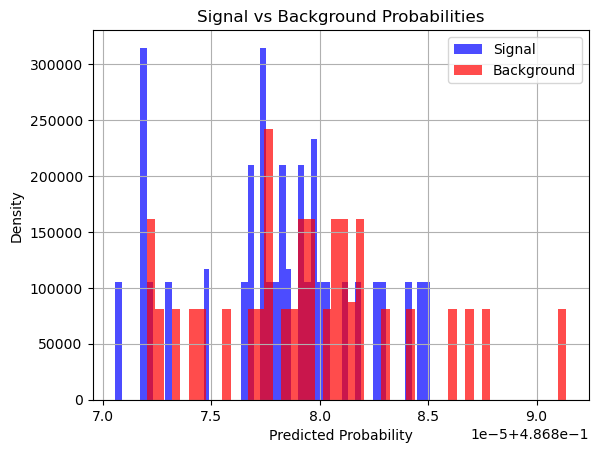

C:\Users\sande\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.7315, Precision: 0.6827, Recall: 0.8650, F1 Score: 0.7631, ROC AUC: 0.8246


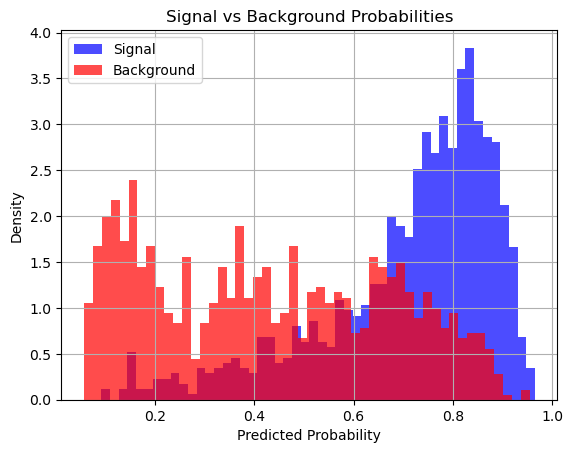

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.7680, Precision: 0.8681, Recall: 0.6320, F1 Score: 0.7315, ROC AUC: 0.8690


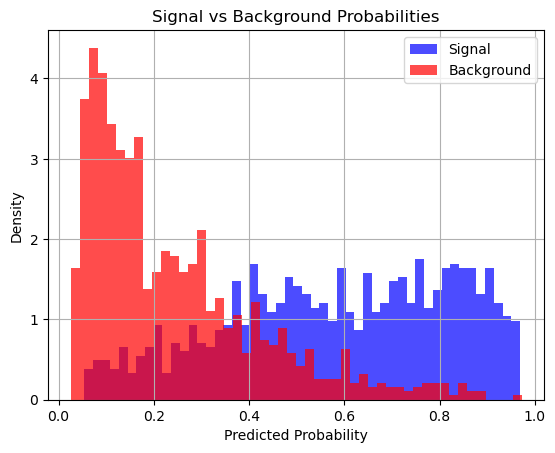

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8000, Precision: 0.8125, Recall: 0.7800, F1 Score: 0.7959, ROC AUC: 0.8784


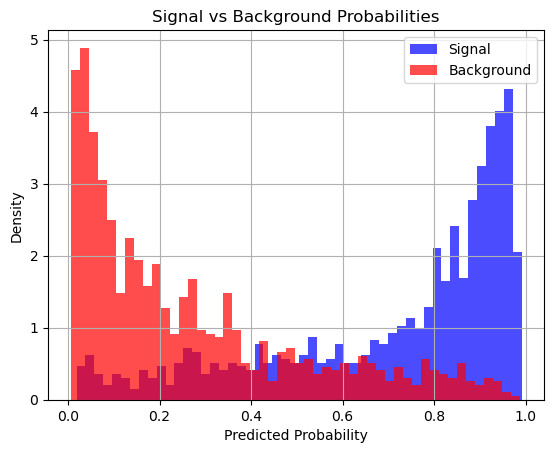

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8040, Precision: 0.7951, Recall: 0.8190, F1 Score: 0.8069, ROC AUC: 0.8820


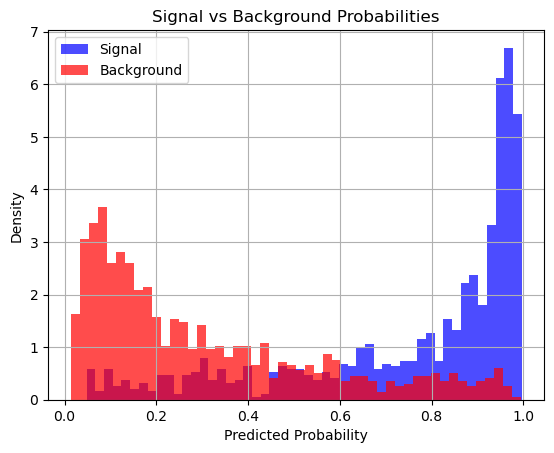

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8080, Precision: 0.7857, Recall: 0.8470, F1 Score: 0.8152, ROC AUC: 0.8861


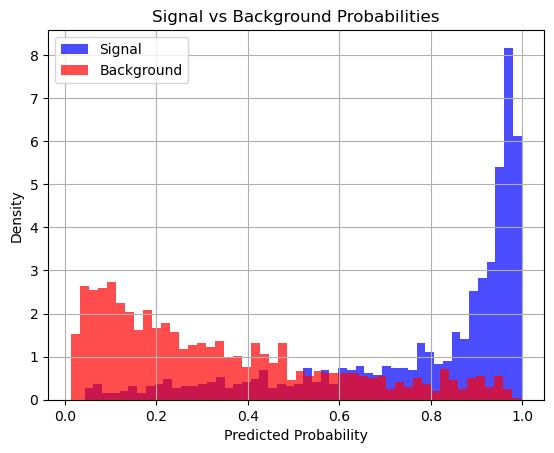

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8220, Precision: 0.8313, Recall: 0.8080, F1 Score: 0.8195, ROC AUC: 0.8924


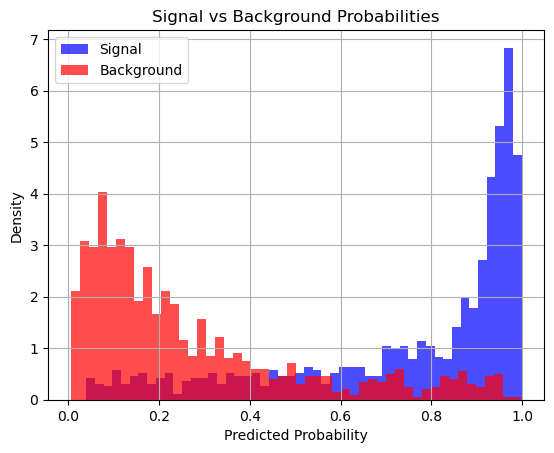

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8205, Precision: 0.8465, Recall: 0.7830, F1 Score: 0.8135, ROC AUC: 0.8941


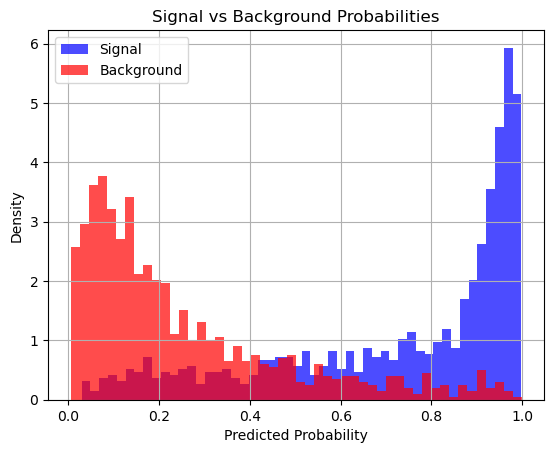

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8120, Precision: 0.7884, Recall: 0.8530, F1 Score: 0.8194, ROC AUC: 0.8912


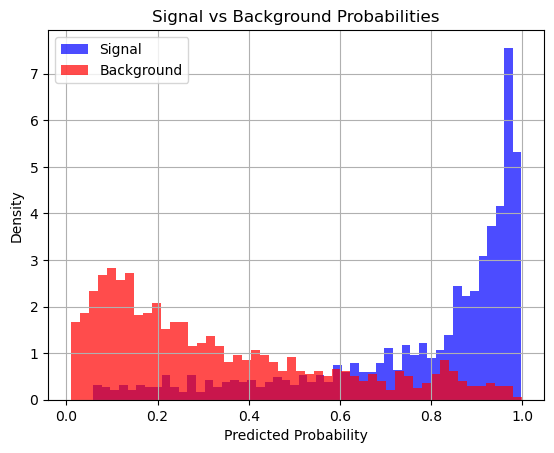

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8170, Precision: 0.8351, Recall: 0.7900, F1 Score: 0.8119, ROC AUC: 0.8953


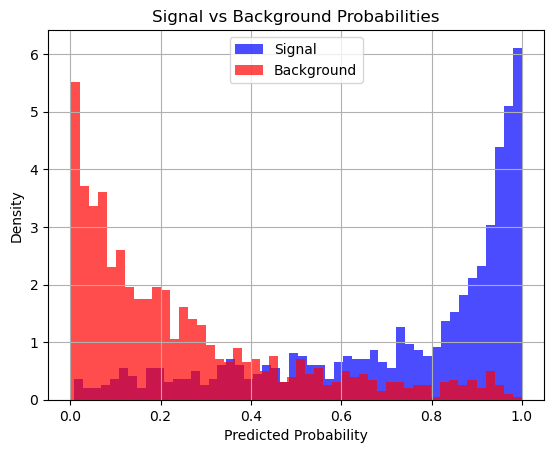

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8210, Precision: 0.8452, Recall: 0.7860, F1 Score: 0.8145, ROC AUC: 0.9006


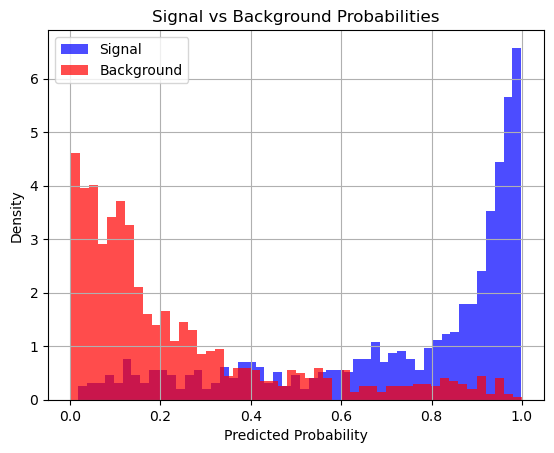

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8290, Precision: 0.8615, Recall: 0.7840, F1 Score: 0.8209, ROC AUC: 0.9014


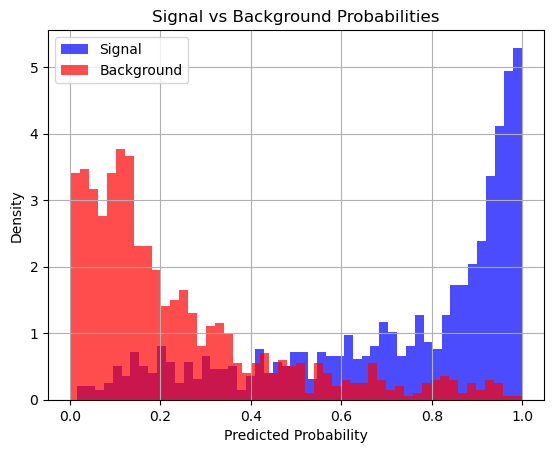

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8270, Precision: 0.8547, Recall: 0.7880, F1 Score: 0.8200, ROC AUC: 0.9040


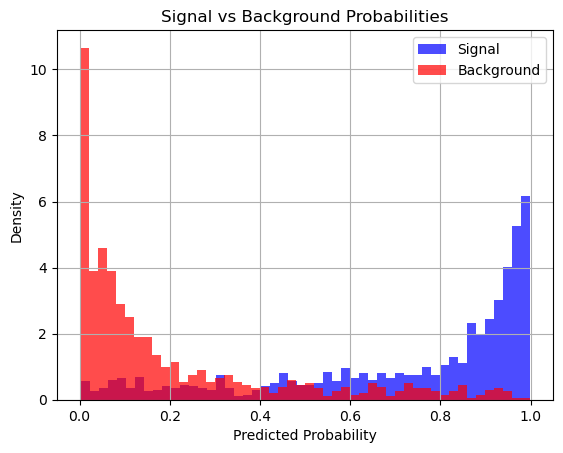

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8215, Precision: 0.8318, Recall: 0.8060, F1 Score: 0.8187, ROC AUC: 0.9051


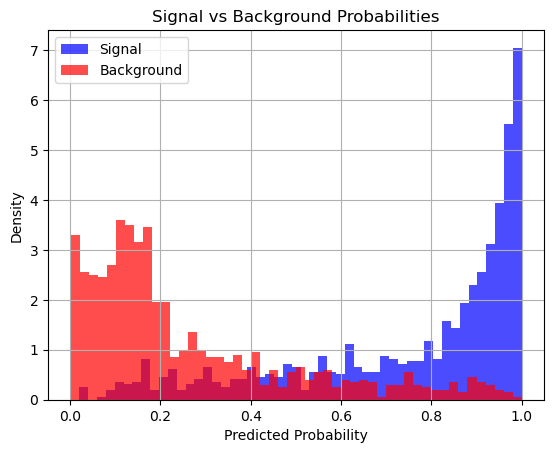

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8245, Precision: 0.8751, Recall: 0.7570, F1 Score: 0.8118, ROC AUC: 0.9073


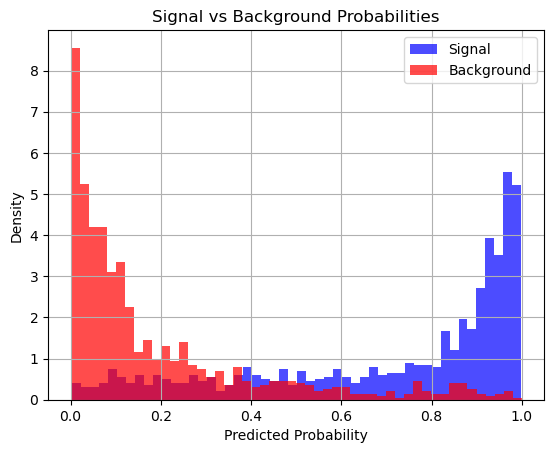

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8310, Precision: 0.8567, Recall: 0.7950, F1 Score: 0.8247, ROC AUC: 0.9085


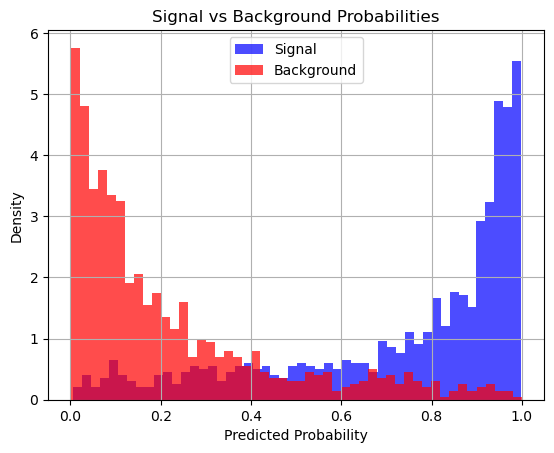

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8325, Precision: 0.8732, Recall: 0.7780, F1 Score: 0.8228, ROC AUC: 0.9087


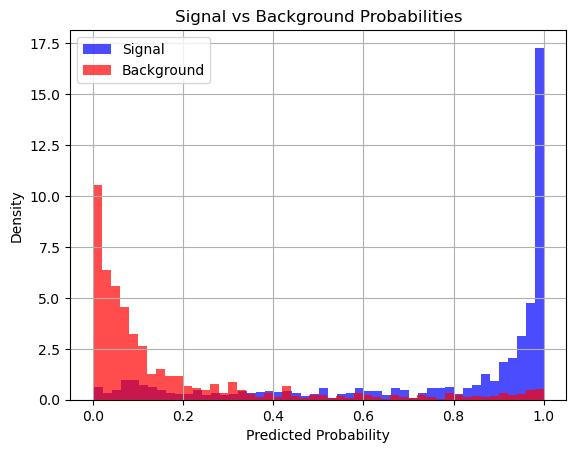

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8285, Precision: 0.8780, Recall: 0.7630, F1 Score: 0.8165, ROC AUC: 0.9088


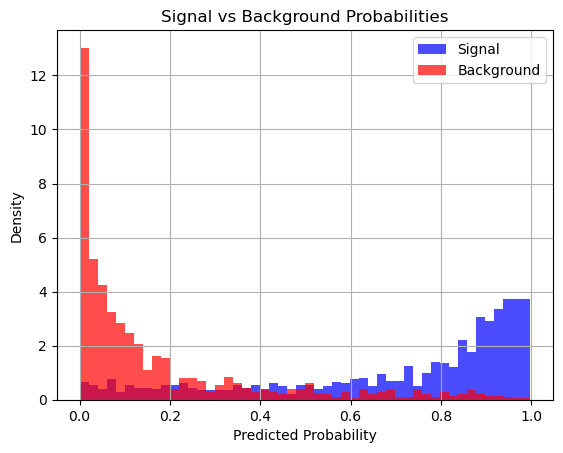

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8240, Precision: 0.8913, Recall: 0.7380, F1 Score: 0.8074, ROC AUC: 0.9069


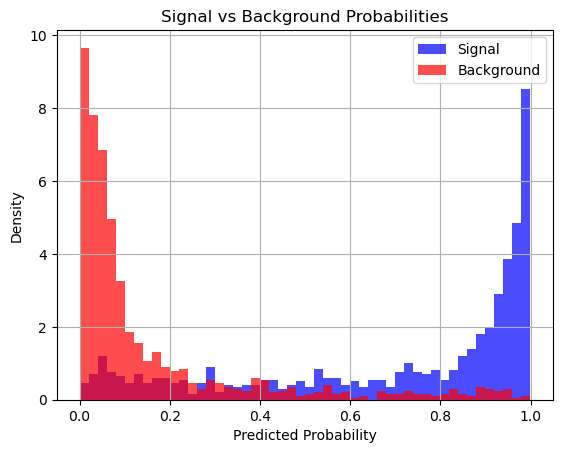

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8345, Precision: 0.8601, Recall: 0.7990, F1 Score: 0.8284, ROC AUC: 0.9059


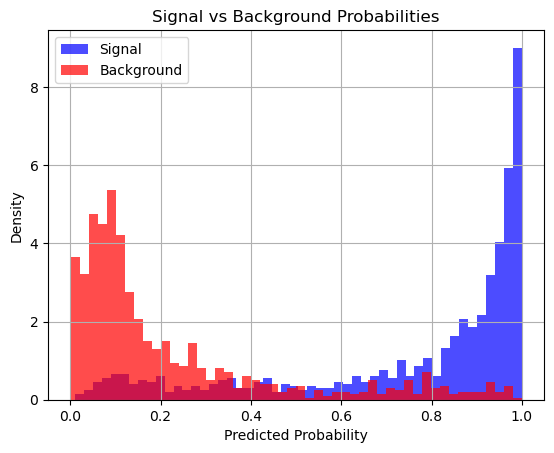

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8310, Precision: 0.8290, Recall: 0.8340, F1 Score: 0.8315, ROC AUC: 0.9041


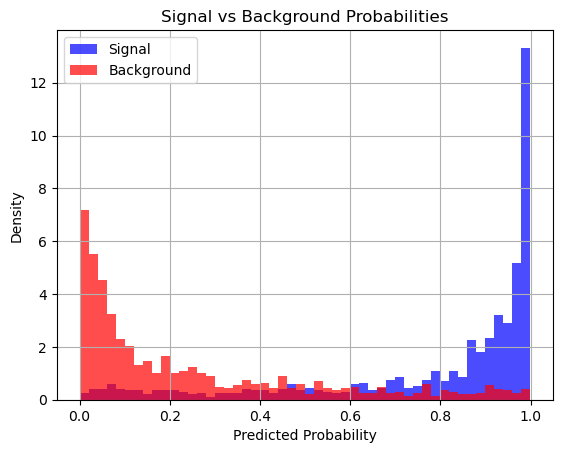

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8325, Precision: 0.8963, Recall: 0.7520, F1 Score: 0.8178, ROC AUC: 0.9089


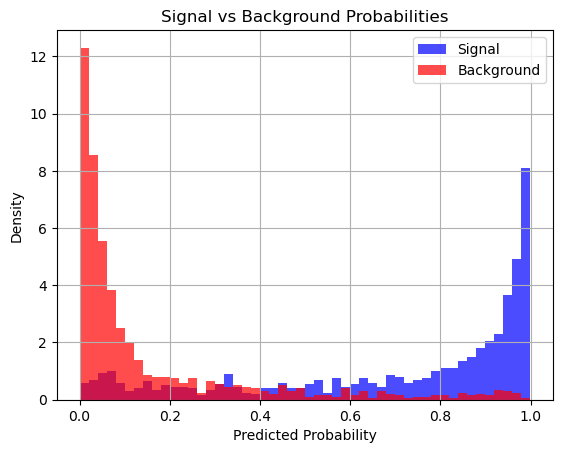

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8320, Precision: 0.8120, Recall: 0.8640, F1 Score: 0.8372, ROC AUC: 0.9049


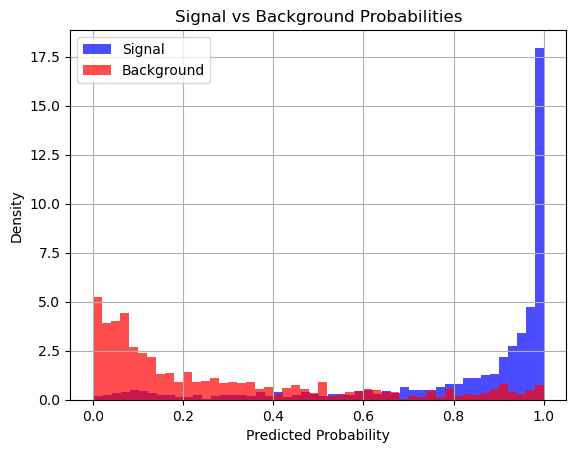

Validation: |          | 0/? [00:00<?, ?it/s]


Validation Results:
Accuracy: 0.8395, Precision: 0.8743, Recall: 0.7930, F1 Score: 0.8317, ROC AUC: 0.9083


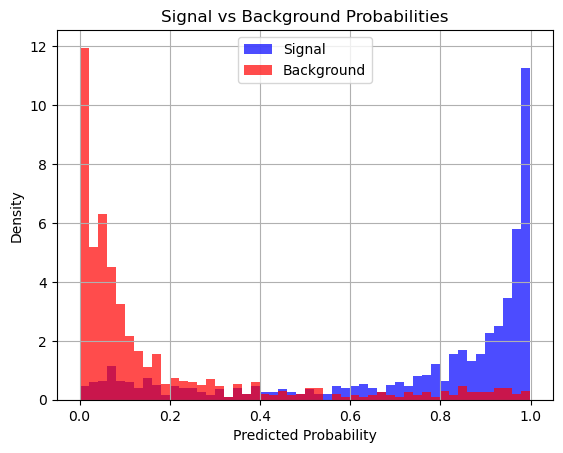


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [6]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import uproot
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from HyPER.models import MPNNs, HyperedgeModel, HyperedgeLoss, EdgeLoss, CombinedLoss
from torchmetrics.classification import BinaryAccuracy

# Configuration
jet_features = ['Jet.PT', 'Jet.Phi', 'Jet.Mass', 'Jet.NCharged', 'Jet.EhadOverEem',
                'Jet.Eta', 'Jet.BTag', 'Jet.Flavor', 'Jet.T', 'Jet.DeltaEta',
                'Jet.DeltaPhi', 'Jet.ChargedEnergyFraction', 'Jet.NeutralEnergyFraction']
lepton_features = ['Electron.PT', 'Electron.Eta', 'Electron.Phi', 'Muon.PT', 'Muon.Eta', 'Muon.Phi']
met_features = ['MissingET.MET', 'MissingET.Phi']
all_features = jet_features + lepton_features + met_features

signal_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_signal_5k.root'
background_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_BKG_5k.root'
tree_name = 'Delphes'
batch_size = 32
delta_r_threshold = 2

# Helper functions
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(delta_eta**2 + delta_phi**2)

def normalize_features(x):
    if x.shape[0] == 0:
        return x
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)

def convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_thresh=2.0):
    N = x_all.shape[0]
    if N == 0:
        return None

    edge_index_list = []
    edge_attr_list = []
    edge_target_list = []
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            dr = delta_r(eta_all[i], phi_all[i], eta_all[j], phi_all[j])
            edge_index_list.append([i, j])
            edge_attr_list.append([dr])
            edge_target_list.append([1 if dr < delta_r_thresh else 0])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).T
    edge_attr_s = torch.tensor(edge_attr_list, dtype=torch.float)
    edge_attr_t = torch.tensor(edge_target_list, dtype=torch.float)

    hyperedge_list = []
    for j in range(N):
        neighbors = [j]
        for k in range(N):
            if j != k and delta_r(eta_all[j], phi_all[j], eta_all[k], phi_all[k]) < delta_r_thresh:
                neighbors.append(k)
        if len(neighbors) > 1:
            hyperedge_list.append(neighbors)

    if not hyperedge_list:
        return None

    node_indices = np.concatenate(hyperedge_list).astype(np.int64)
    hyperedge_indices = np.repeat(np.arange(len(hyperedge_list)), [len(h) for h in hyperedge_list]).astype(np.int64)
    hyperedge_index = torch.from_numpy(np.stack([node_indices, hyperedge_indices])).long()

    u_s = torch.tensor([[x_all[:, 0].sum(), x_all[:, 1].mean()]], dtype=torch.float)

    data = Data(
        x_s=torch.tensor(x_all, dtype=torch.float),
        u_s=u_s,
        edge_index=edge_index,
        edge_attr_s=edge_attr_s,
        edge_attr_s_batch=torch.zeros(edge_index.shape[1], dtype=torch.long),
        edge_attr_t=edge_attr_t.view(-1, 1),
        edge_index_h=hyperedge_index,
        edge_index_h_batch=torch.zeros(hyperedge_index.shape[1], dtype=torch.long),
        x_t=torch.tensor([label], dtype=torch.float),
        batch=torch.zeros(N, dtype=torch.long)
    )
    return data

def load_data_hyper_format(file_path, label):
    file = uproot.open(file_path)
    tree = file[tree_name]
    events = tree.arrays(all_features, library='np')
    data_list = []

    num_events = len(events[jet_features[0]])
    for i in range(num_events):
        jet_data = [events[feat][i] for feat in jet_features]
        x_jets = np.column_stack(jet_data)
        x_jets = np.nan_to_num(x_jets)
        x_jets = normalize_features(x_jets)

        elec_data = [events[feat][i] for feat in lepton_features[:3]]
        muon_data = [events[feat][i] for feat in lepton_features[3:]]
        x_elec = np.column_stack(elec_data) if len(elec_data[0]) > 0 else np.empty((0, 3))
        x_muon = np.column_stack(muon_data) if len(muon_data[0]) > 0 else np.empty((0, 3))
        x_leptons = np.vstack([x_elec, x_muon])

        if x_leptons.size == 0:
            x_leptons = np.zeros((0, 13))
        elif x_leptons.shape[1] != 13:
            x_leptons = np.pad(x_leptons, ((0, 0), (0, 13 - x_leptons.shape[1])), mode='constant')
        x_leptons = normalize_features(x_leptons)

        met_data = [events[feat][i] for feat in met_features]
        x_met = np.array(met_data).reshape(1, -1)
        x_met = np.nan_to_num(x_met)
        if x_met.shape[1] != 13:
            x_met = np.pad(x_met, ((0, 0), (0, 13 - x_met.shape[1])), mode='constant')
        x_met = normalize_features(x_met)

        x_all = np.vstack([x_jets, x_leptons, x_met])
        eta_all = np.concatenate([
            x_jets[:, 5] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 1] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 1] if x_met.shape[0] > 0 else np.array([])
        ])
        phi_all = np.concatenate([
            x_jets[:, 1] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 2] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 0] if x_met.shape[0] > 0 else np.array([])
        ])

        data = convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_threshold)
        if data:
            data_list.append(data)

    return data_list

# Load full dataset
signal_data = load_data_hyper_format(signal_file, 1)
background_data = load_data_hyper_format(background_file, 0)
dataset = signal_data + background_data
np.random.shuffle(dataset)
split = int(0.8 * len(dataset))
train_data = dataset[:split]
test_data = dataset[split:]
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Define LightningModule
class HyPERModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MPNNs(
            node_in_channels=13,
            edge_in_channels=1,
            global_in_channels=2,
            node_out_channels=32,
            edge_out_channels=1,
            global_out_channels=32,
            message_feats=32,
            dropout=0.01,
            activation=Sigmoid(),
            p_out='edge'
        )
        self.hyper = HyperedgeModel(
            node_in_channels=32,
            node_out_channels=1,
            global_in_channels=32,
            message_feats=32,
            dropout=0.01
        )
        self.criterion_edge = BCELoss(reduction='none')
        self.criterion_hyper = BCELoss()
        self.alpha = 0.5
        self.y_true, self.y_score = [], []

    def forward(self, data):
        x, edge_attr, u = self.model(
            data.x_s, data.edge_index, data.edge_attr_s, data.u_s, data.batch
        )
        x_hat, batch_hyper = self.hyper(
            x, u, data.batch, data.edge_index_h, data.edge_index_h_batch, 3
        )
        return x_hat, batch_hyper, edge_attr

    def training_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)

        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        loss_hyper = self.criterion_hyper(
            x_event_pred.view(-1), batch.x_t.float().view(-1)
        )
        loss_edge = EdgeLoss(
            edge_attr_prime.view(-1),
            batch.edge_attr_t.view(-1),
            batch.edge_attr_s_batch,
            self.criterion_edge,
            reduction='mean'
        )
        loss = CombinedLoss(loss_edge, loss_hyper, self.alpha, 'mean')
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)
        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        pred_probs = x_event_pred.detach().cpu().numpy()
        true_labels = batch.x_t.detach().cpu().numpy()

        self.y_score.extend(pred_probs)
        self.y_true.extend(true_labels)

        pred_class = (x_event_pred > 0.5).float()
        acc = (pred_class == batch.x_t.float()).float().mean()
        self.log('val_acc_hyper', acc)

    def on_validation_epoch_end(self):
        y_true = np.array(self.y_true)
        y_pred = np.array(self.y_score)
        y_pred_class = (y_pred > 0.5).astype(int)

        acc = accuracy_score(y_true, y_pred_class)
        prec = precision_score(y_true, y_pred_class)
        rec = recall_score(y_true, y_pred_class)
        f1 = f1_score(y_true, y_pred_class)
        roc = roc_auc_score(y_true, y_pred)

        print("\nValidation Results:")
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc:.4f}")

        plt.hist(y_pred[y_true == 1], bins=50, alpha=0.7, label='Signal', color='blue', density=True)
        plt.hist(y_pred[y_true == 0], bins=50, alpha=0.7, label='Background', color='red', density=True)
        plt.xlabel('Predicted Probability')
        plt.ylabel('Density')
        plt.title('Signal vs Background Probabilities')
        plt.legend()
        plt.grid()
        plt.show()

        self.y_true.clear()
        self.y_score.clear()

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=10)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "val_acc_hyper",
                "frequency": 1,
                "strict": True
            },
        }

# Train the model
model = HyPERModel()
trainer = Trainer(max_epochs=30, accelerator='auto')
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import uproot
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from HyPER.models import MPNNs, HyperedgeModel, HyperedgeLoss, EdgeLoss, CombinedLoss
from torchmetrics.classification import BinaryAccuracy
import seaborn as sns
import joblib
import os

# Configuration
jet_features = ['Jet.PT', 'Jet.Phi', 'Jet.Mass', 'Jet.NCharged', 'Jet.EhadOverEem',
                'Jet.Eta', 'Jet.BTag', 'Jet.Flavor', 'Jet.T', 'Jet.DeltaEta',
                'Jet.DeltaPhi', 'Jet.ChargedEnergyFraction', 'Jet.NeutralEnergyFraction']
lepton_features = ['Electron.PT', 'Electron.Eta', 'Electron.Phi', 'Muon.PT', 'Muon.Eta', 'Muon.Phi']
met_features = ['MissingET.MET', 'MissingET.Phi']
all_features = jet_features + lepton_features + met_features

signal_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_signal_5k.root'
background_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_BKG_5k.root'
tree_name = 'Delphes'
batch_size = 32
delta_r_threshold = 2

os.makedirs("results", exist_ok=True)

# Helper functions
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(delta_eta**2 + delta_phi**2)

def normalize_features(x):
    if x.shape[0] == 0:
        return x
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)

def convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_thresh=2.0):
    N = x_all.shape[0]
    if N == 0:
        return None

    edge_index_list = []
    edge_attr_list = []
    edge_target_list = []
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            dr = delta_r(eta_all[i], phi_all[i], eta_all[j], phi_all[j])
            edge_index_list.append([i, j])
            edge_attr_list.append([dr])
            edge_target_list.append([1 if dr < delta_r_thresh else 0])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).T
    edge_attr_s = torch.tensor(edge_attr_list, dtype=torch.float)
    edge_attr_t = torch.tensor(edge_target_list, dtype=torch.float)

    hyperedge_list = []
    for j in range(N):
        neighbors = [j]
        for k in range(N):
            if j != k and delta_r(eta_all[j], phi_all[j], eta_all[k], phi_all[k]) < delta_r_thresh:
                neighbors.append(k)
        if len(neighbors) > 1:
            hyperedge_list.append(neighbors)

    if not hyperedge_list:
        return None

    node_indices = np.concatenate(hyperedge_list).astype(np.int64)
    hyperedge_indices = np.repeat(np.arange(len(hyperedge_list)), [len(h) for h in hyperedge_list]).astype(np.int64)
    hyperedge_index = torch.from_numpy(np.stack([node_indices, hyperedge_indices])).long()

    u_s = torch.tensor([[x_all[:, 0].sum(), x_all[:, 1].mean()]], dtype=torch.float)

    data = Data(
        x_s=torch.tensor(x_all, dtype=torch.float),
        u_s=u_s,
        edge_index=edge_index,
        edge_attr_s=edge_attr_s,
        edge_attr_s_batch=torch.zeros(edge_index.shape[1], dtype=torch.long),
        edge_attr_t=edge_attr_t.view(-1, 1),
        edge_index_h=hyperedge_index,
        edge_index_h_batch=torch.zeros(hyperedge_index.shape[1], dtype=torch.long),
        x_t=torch.tensor([label], dtype=torch.float),
        batch=torch.zeros(N, dtype=torch.long)
    )
    return data

def load_data_hyper_format(file_path, label):
    file = uproot.open(file_path)
    tree = file[tree_name]
    events = tree.arrays(all_features, library='np')
    data_list = []

    num_events = len(events[jet_features[0]])
    for i in range(num_events):
        jet_data = [events[feat][i] for feat in jet_features]
        x_jets = np.column_stack(jet_data)
        x_jets = np.nan_to_num(x_jets)
        x_jets = normalize_features(x_jets)

        elec_data = [events[feat][i] for feat in lepton_features[:3]]
        muon_data = [events[feat][i] for feat in lepton_features[3:]]
        x_elec = np.column_stack(elec_data) if len(elec_data[0]) > 0 else np.empty((0, 3))
        x_muon = np.column_stack(muon_data) if len(muon_data[0]) > 0 else np.empty((0, 3))
        x_leptons = np.vstack([x_elec, x_muon])

        if x_leptons.size == 0:
            x_leptons = np.zeros((0, 13))
        elif x_leptons.shape[1] != 13:
            x_leptons = np.pad(x_leptons, ((0, 0), (0, 13 - x_leptons.shape[1])), mode='constant')
        x_leptons = normalize_features(x_leptons)

        met_data = [events[feat][i] for feat in met_features]
        x_met = np.array(met_data).reshape(1, -1)
        x_met = np.nan_to_num(x_met)
        if x_met.shape[1] != 13:
            x_met = np.pad(x_met, ((0, 0), (0, 13 - x_met.shape[1])), mode='constant')
        x_met = normalize_features(x_met)

        x_all = np.vstack([x_jets, x_leptons, x_met])
        eta_all = np.concatenate([
            x_jets[:, 5] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 1] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 1] if x_met.shape[0] > 0 else np.array([])
        ])
        phi_all = np.concatenate([
            x_jets[:, 1] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 2] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 0] if x_met.shape[0] > 0 else np.array([])
        ])

        data = convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_threshold)
        if data:
            data_list.append(data)

    return data_list

# Load full dataset
signal_data = load_data_hyper_format(signal_file, 1)
background_data = load_data_hyper_format(background_file, 0)
dataset = signal_data + background_data
np.random.shuffle(dataset)
split = int(0.8 * len(dataset))
train_data = dataset[:split]
test_data = dataset[split:]
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

# TensorBoard logger
logger = TensorBoardLogger("lightning_logs", name="hypergraph")

# Define LightningModule
class HyPERModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MPNNs(
            node_in_channels=13,
            edge_in_channels=1,
            global_in_channels=2,
            node_out_channels=32,
            edge_out_channels=1,
            global_out_channels=32,
            message_feats=32,
            dropout=0.01,
            activation=Sigmoid(),
            p_out='edge'
        )
        self.hyper = HyperedgeModel(
            node_in_channels=32,
            node_out_channels=1,
            global_in_channels=32,
            message_feats=32,
            dropout=0.01
        )
        self.criterion_edge = BCELoss(reduction='none')
        self.criterion_hyper = BCELoss()
        self.alpha = 0.5
        self.y_true, self.y_score = [], []

    def forward(self, data):
        x, edge_attr, u = self.model(
            data.x_s, data.edge_index, data.edge_attr_s, data.u_s, data.batch
        )
        x_hat, batch_hyper = self.hyper(
            x, u, data.batch, data.edge_index_h, data.edge_index_h_batch, 3
        )
        return x_hat, batch_hyper, edge_attr

    def training_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)
        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        loss_hyper = self.criterion_hyper(
            x_event_pred.view(-1), batch.x_t.float().view(-1)
        )
        loss_edge = EdgeLoss(
            edge_attr_prime.view(-1),
            batch.edge_attr_t.view(-1),
            batch.edge_attr_s_batch,
            self.criterion_edge,
            reduction='mean'
        )
        loss = CombinedLoss(loss_edge, loss_hyper, self.alpha, 'mean')
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)
        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        pred_probs = x_event_pred.detach().cpu().numpy()
        true_labels = batch.x_t.detach().cpu().numpy()
        self.y_score.extend(pred_probs)
        self.y_true.extend(true_labels)

        pred_class = (x_event_pred > 0.5).float()
        acc = (pred_class == batch.x_t.float()).float().mean()
        self.log('val_acc_hyper', acc, prog_bar=True)

    def on_validation_epoch_end(self):
        y_true = np.array(self.y_true)
        y_pred = np.array(self.y_score)
        y_pred_class = (y_pred > 0.5).astype(int)

        acc = accuracy_score(y_true, y_pred_class)
        prec = precision_score(y_true, y_pred_class)
        rec = recall_score(y_true, y_pred_class)
        f1 = f1_score(y_true, y_pred_class)
        roc = roc_auc_score(y_true, y_pred)

        self.log('val_roc_auc', roc, prog_bar=True, on_epoch=True)
        self.log('val_f1', f1, prog_bar=False, on_epoch=True)
        self.log('val_precision', prec, prog_bar=False, on_epoch=True)
        self.log('val_recall', rec, prog_bar=False, on_epoch=True)

        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC AUC: {roc:.4f}")

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid()
        plt.savefig("results/roc_curve.png")
        plt.savefig("results/roc_curve.pdf")
        plt.show()

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred_class)
        plt.figure()
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.grid(False)
        plt.savefig("results/confusion_matrix.png")
        plt.savefig("results/confusion_matrix.pdf")
        plt.show()

        # Histogram
        plt.figure()
        plt.hist(y_pred[y_true == 1], bins=50, alpha=0.7, label='Signal', color='blue', density=True)
        plt.hist(y_pred[y_true == 0], bins=50, alpha=0.7, label='Background', color='red', density=True)
        plt.xlabel('Predicted Probability')
        plt.ylabel('Density')
        plt.title('Signal vs Background Probabilities')
        plt.legend()
        plt.grid()
        plt.savefig("results/probability_histogram.png")
        plt.savefig("results/probability_histogram.pdf")
        plt.show()

        joblib.dump((y_true, y_pred), 'results/hyper_model_output.pkl')
        torch.save(self.state_dict(), 'results/hyper_model.pt')

        self.y_true.clear()
        self.y_score.clear()

# Train the model
model = HyPERModel()
trainer = Trainer(max_epochs=30, accelerator='auto', logger=logger)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

# Reload and plot if needed
# loaded_model = HyPERModel()
# loaded_model.load_state_dict(torch.load('results/hyper_model.pt'))
# y_true, y_pred = joblib.load('results/hyper_model_output.pkl')
# # Then use y_true/y_pred to plot ROC and confusion matrix again


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MisconfigurationException: No `configure_optimizers()` method defined. Lightning `Trainer` expects as minimum a `training_step()`, `train_dataloader()` and `configure_optimizers()` to be defined.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 6GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | model           | MPNNs          | 14.0 K | train
1 | hyper           | HyperedgeModel | 8.4 K  | train
2 | criterion_edge  | BCELoss        | 0      | train
3 | criterion_hyper | BCELoss        | 0      | train
-----------------------------------------------------------
22.4 K    Trainable params
0         Non-trainable params
22.4 K    Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\sande\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\sande\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ [Epoch 1] Val Accuracy: 0.4844
Accuracy: 0.4844, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC AUC: 0.6105


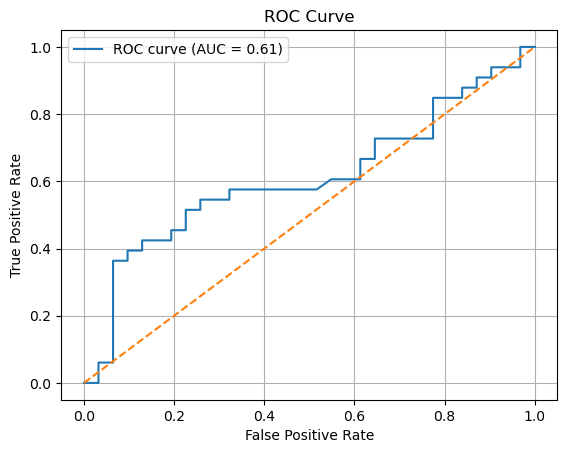

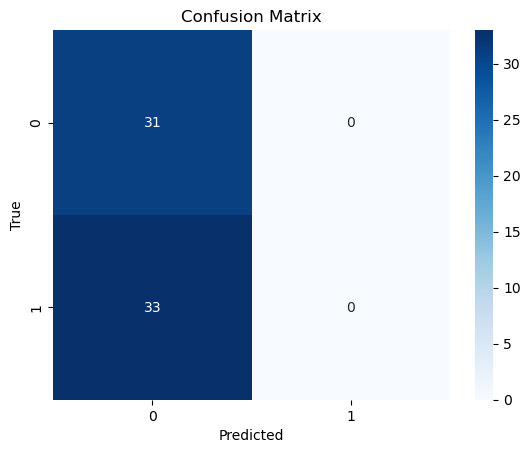

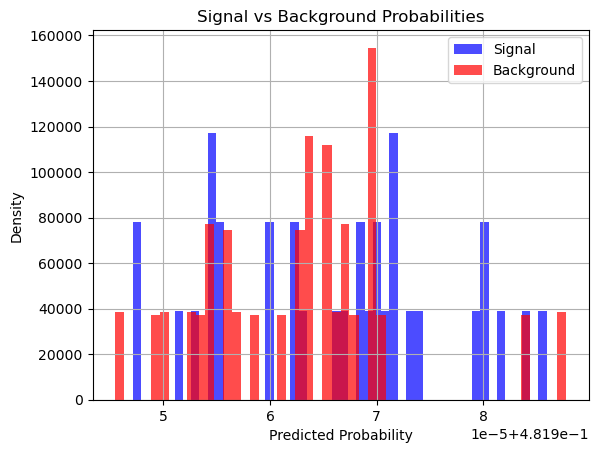


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.


C:\Users\sande\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 1] Val Accuracy: 0.7728
Accuracy: 0.7730, Precision: 0.7454, Recall: 0.8394, F1: 0.7896, ROC AUC: 0.8494


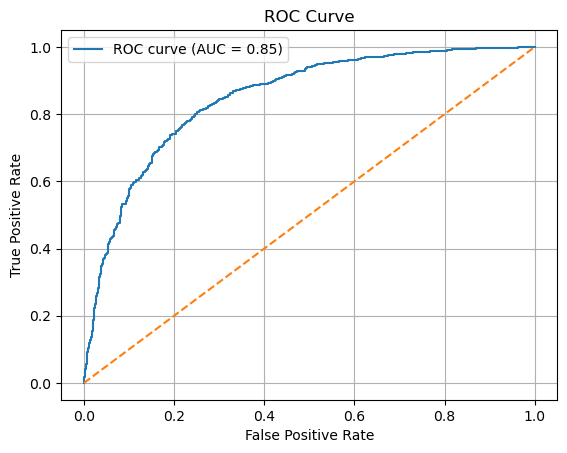

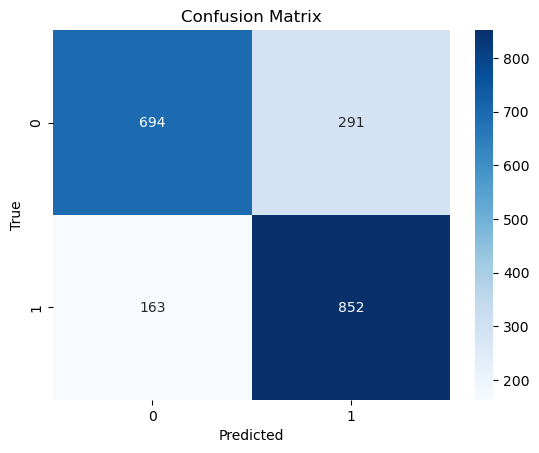

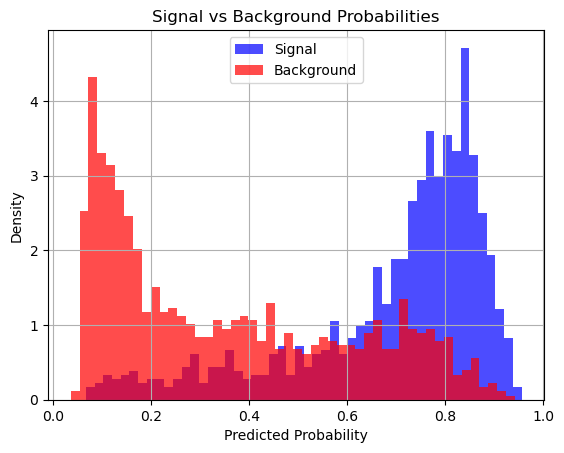


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 1] Train Loss: 0.2963


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 2] Val Accuracy: 0.7927
Accuracy: 0.7925, Precision: 0.7636, Recall: 0.8562, F1: 0.8072, ROC AUC: 0.8840


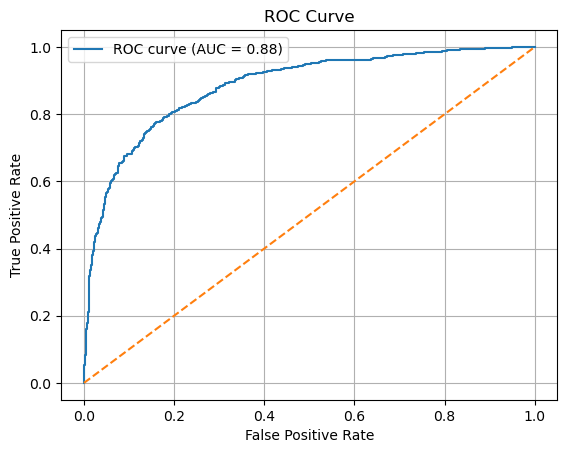

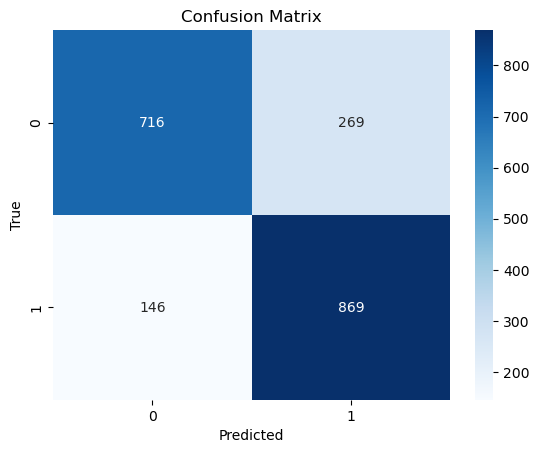

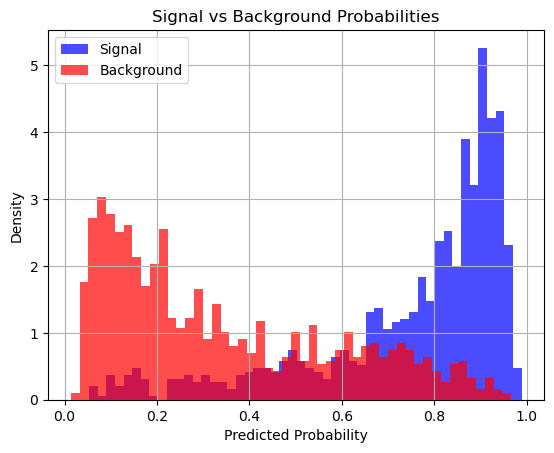


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 2] Train Loss: 0.3216


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 3] Val Accuracy: 0.7971
Accuracy: 0.7970, Precision: 0.7702, Recall: 0.8552, F1: 0.8105, ROC AUC: 0.8857


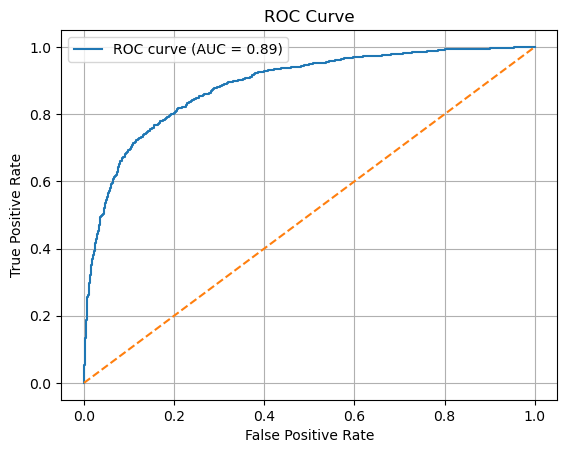

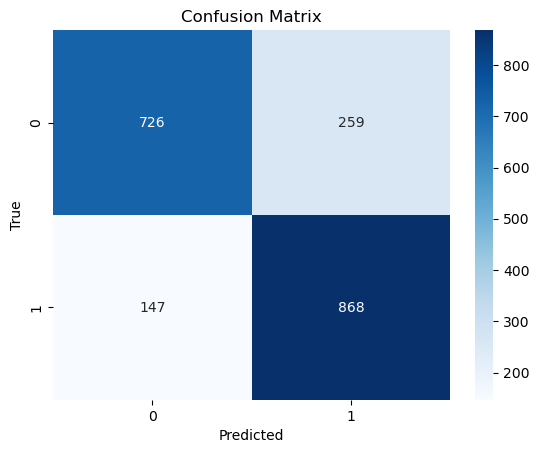

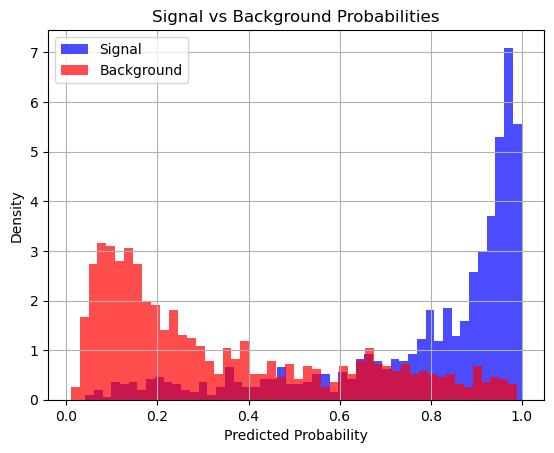


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 3] Train Loss: 0.1800


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 4] Val Accuracy: 0.8090
Accuracy: 0.8090, Precision: 0.7972, Recall: 0.8365, F1: 0.8163, ROC AUC: 0.8961


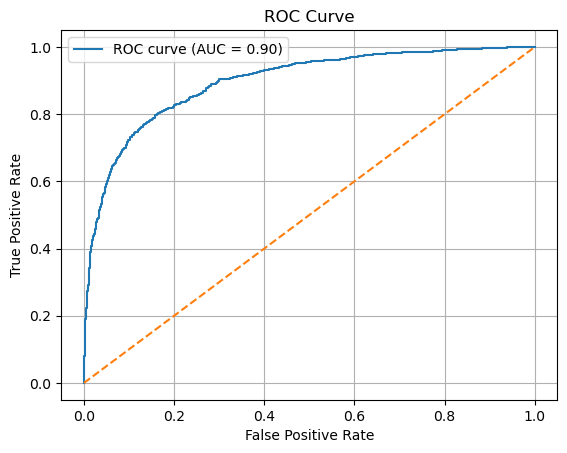

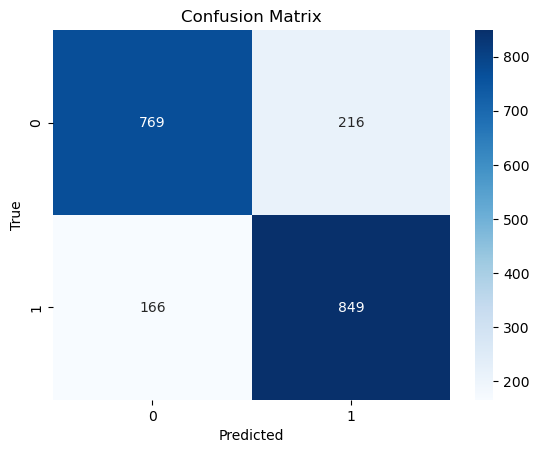

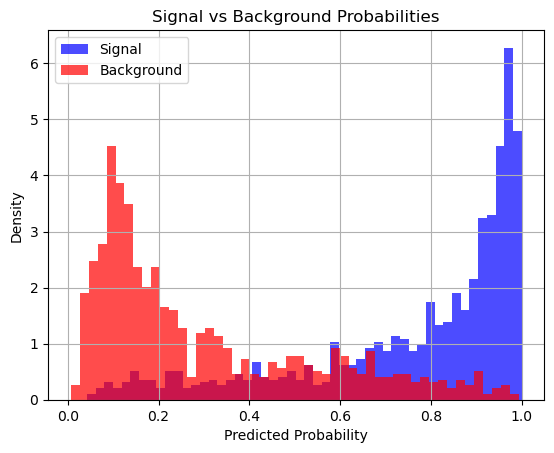


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 4] Train Loss: 0.1895


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 5] Val Accuracy: 0.8135
Accuracy: 0.8145, Precision: 0.8531, Recall: 0.7665, F1: 0.8075, ROC AUC: 0.8993


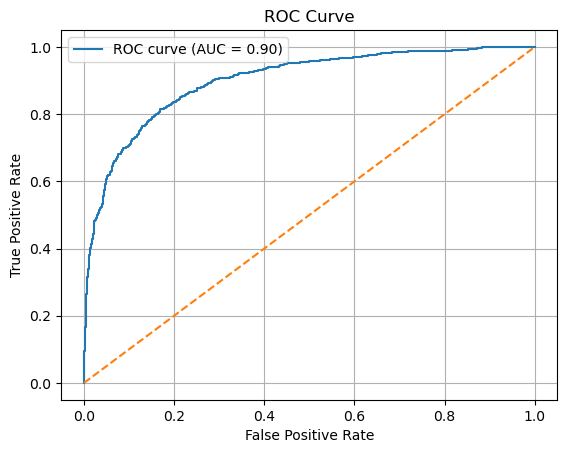

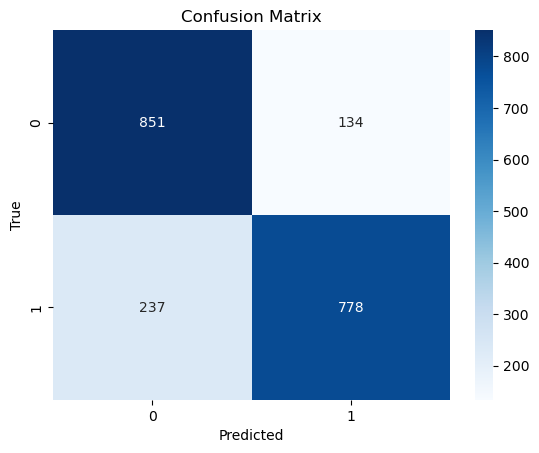

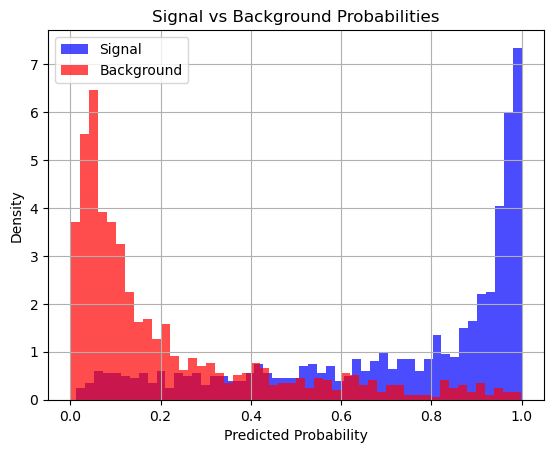


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 5] Train Loss: 0.2386


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 6] Val Accuracy: 0.8234
Accuracy: 0.8240, Precision: 0.8501, Recall: 0.7931, F1: 0.8206, ROC AUC: 0.9049


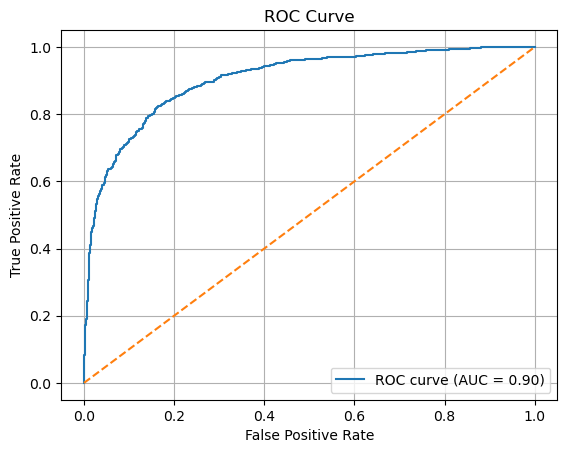

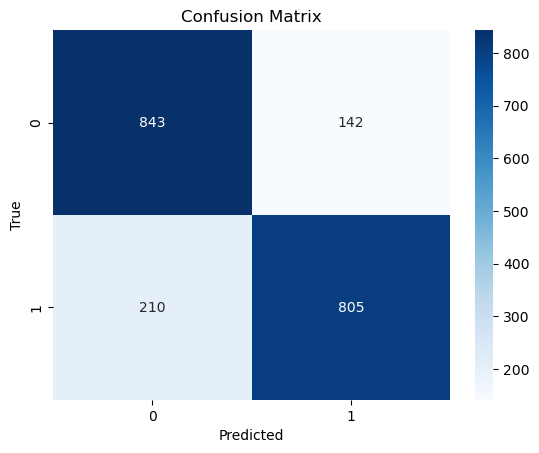

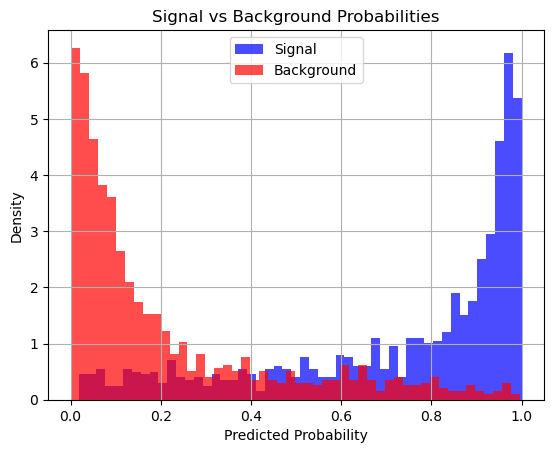


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 6] Train Loss: 0.2232


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 7] Val Accuracy: 0.8095
Accuracy: 0.8100, Precision: 0.8812, Recall: 0.7232, F1: 0.7944, ROC AUC: 0.9064


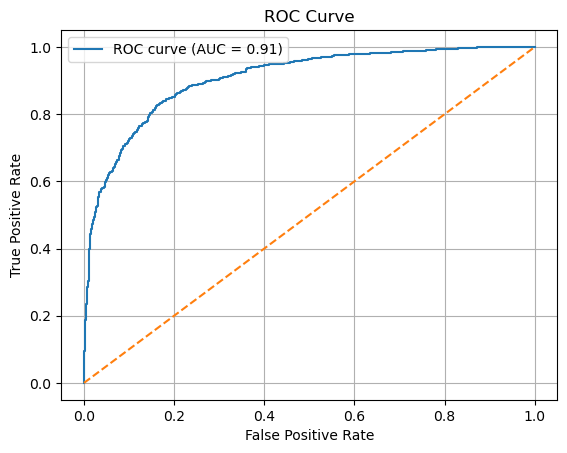

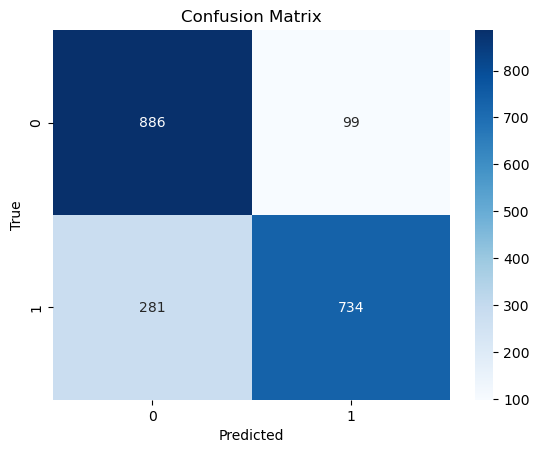

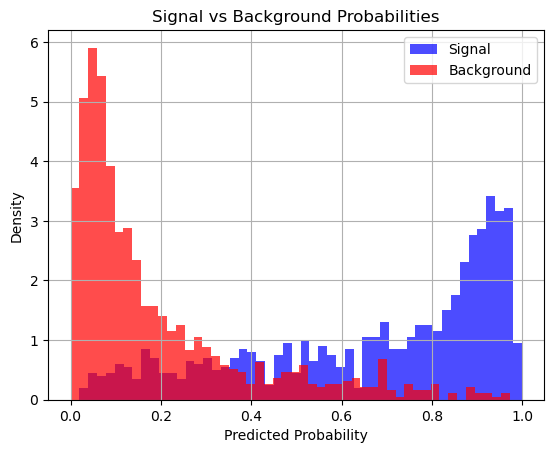


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 7] Train Loss: 0.2219


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 8] Val Accuracy: 0.8249
Accuracy: 0.8255, Precision: 0.8612, Recall: 0.7823, F1: 0.8198, ROC AUC: 0.9099


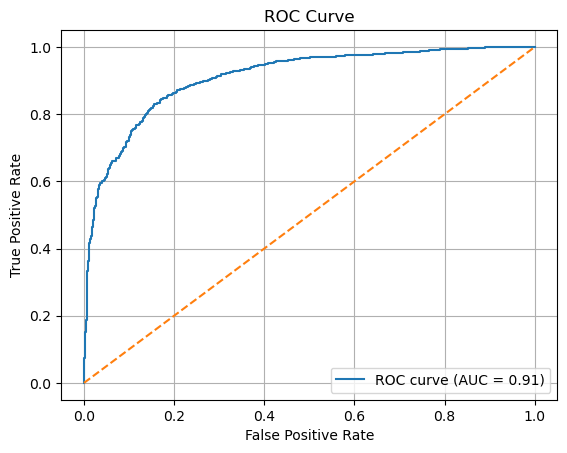

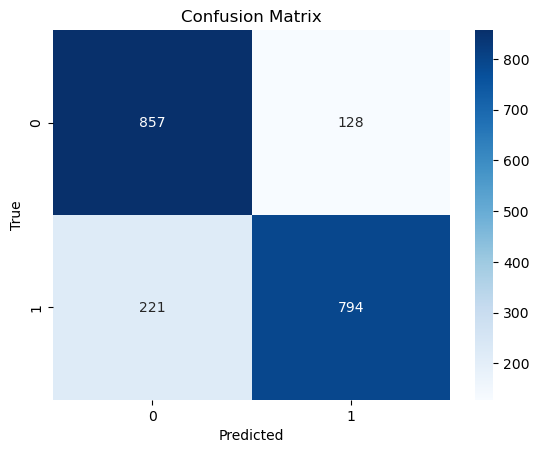

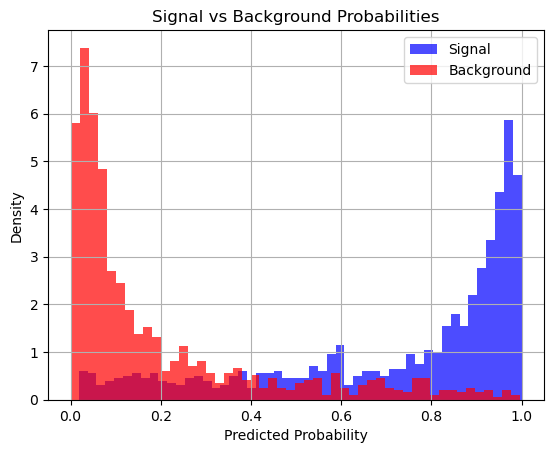


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 8] Train Loss: 0.2034


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 9] Val Accuracy: 0.8080
Accuracy: 0.8095, Precision: 0.9013, Recall: 0.7015, F1: 0.7889, ROC AUC: 0.9085


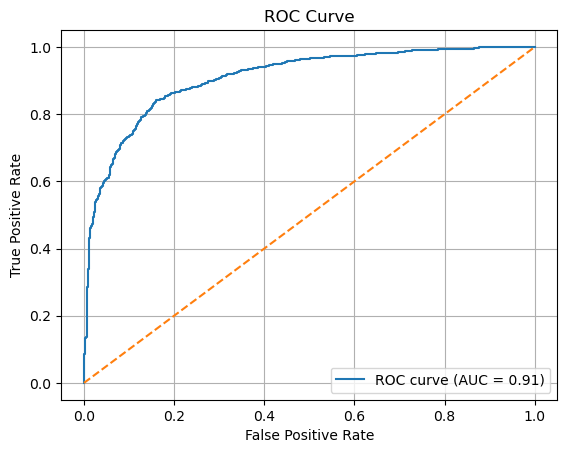

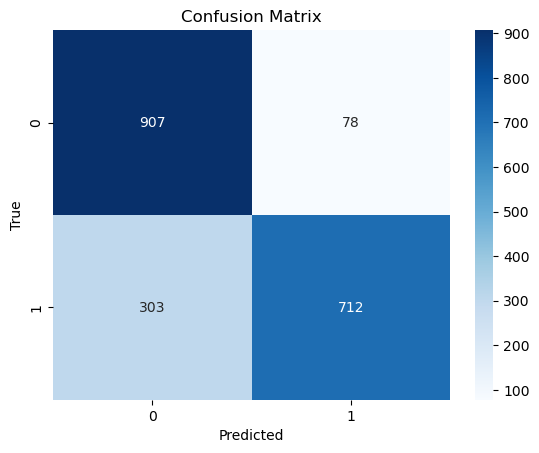

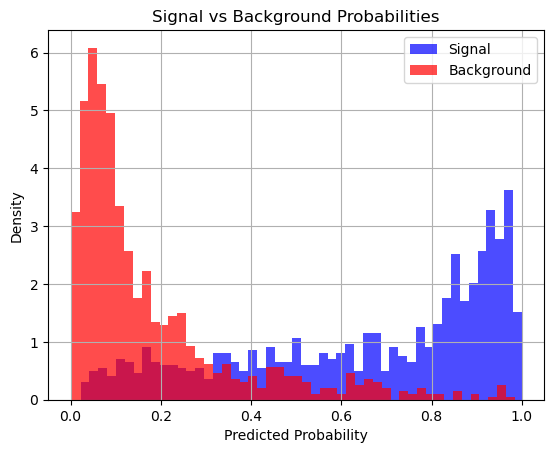


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 9] Train Loss: 0.2437


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 10] Val Accuracy: 0.8358
Accuracy: 0.8355, Precision: 0.8580, Recall: 0.8099, F1: 0.8332, ROC AUC: 0.9085


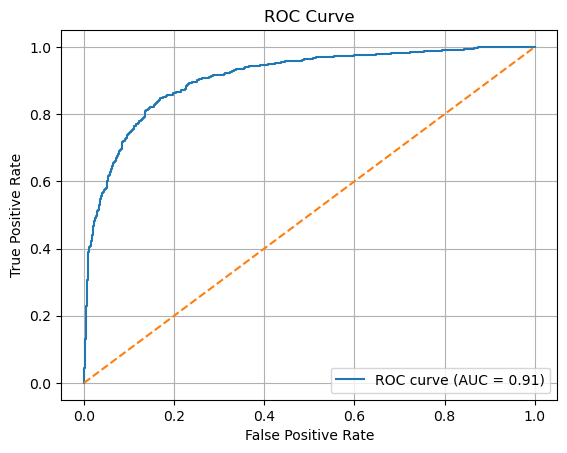

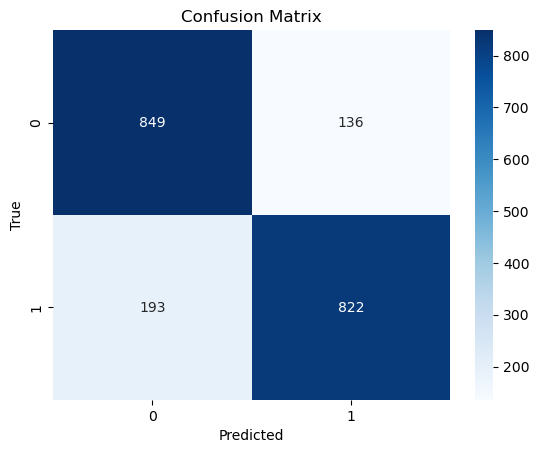

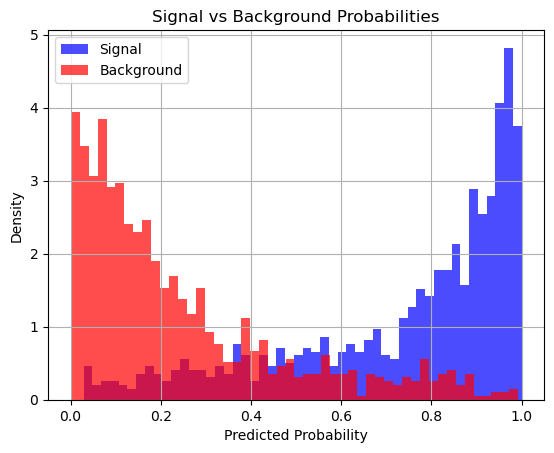


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 10] Train Loss: 0.1805


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 11] Val Accuracy: 0.8239
Accuracy: 0.8235, Precision: 0.7749, Recall: 0.9192, F1: 0.8409, ROC AUC: 0.9167


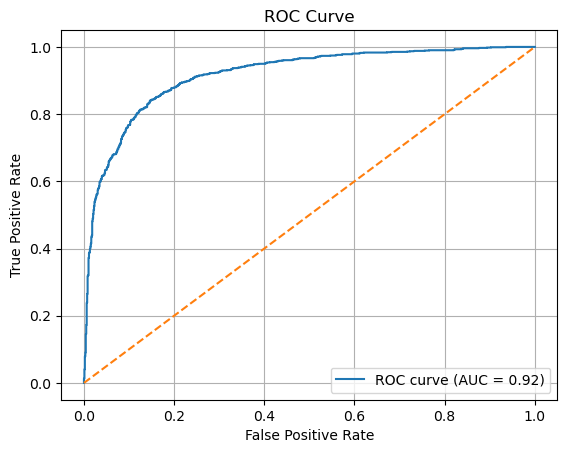

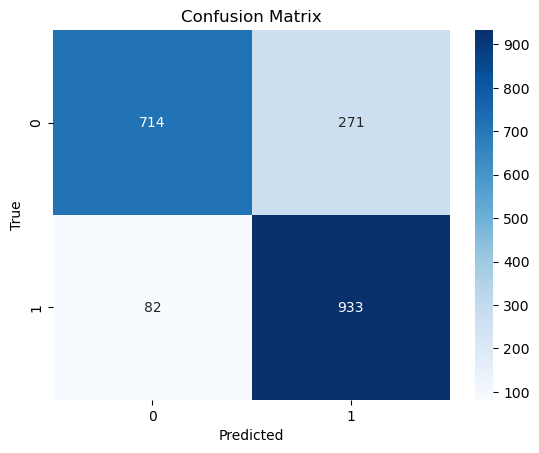

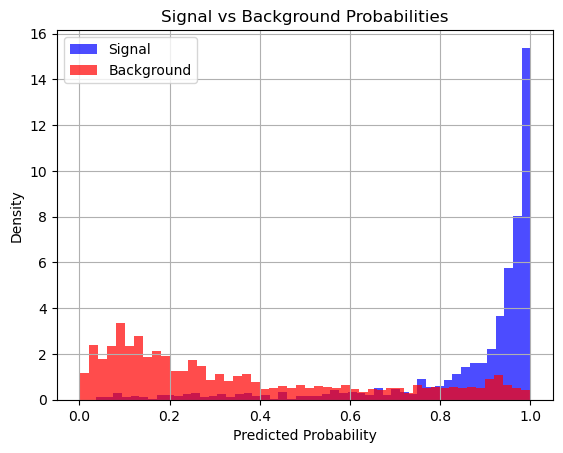


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 11] Train Loss: 0.1500


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 12] Val Accuracy: 0.8433
Accuracy: 0.8430, Precision: 0.8254, Recall: 0.8759, F1: 0.8499, ROC AUC: 0.9151


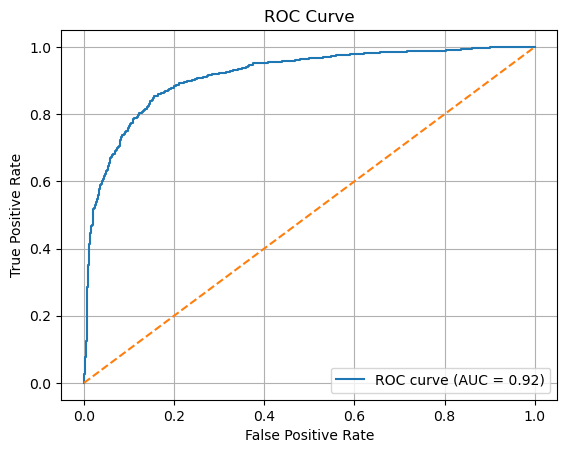

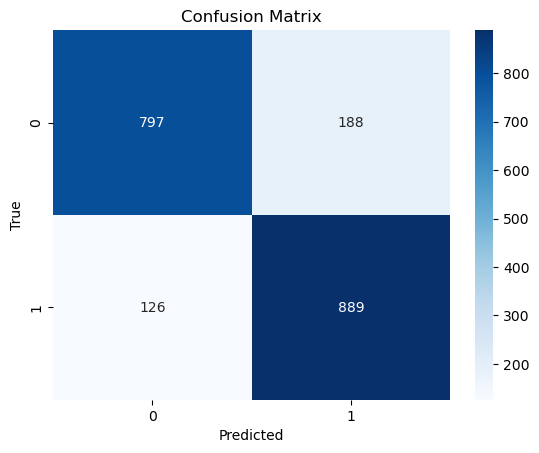

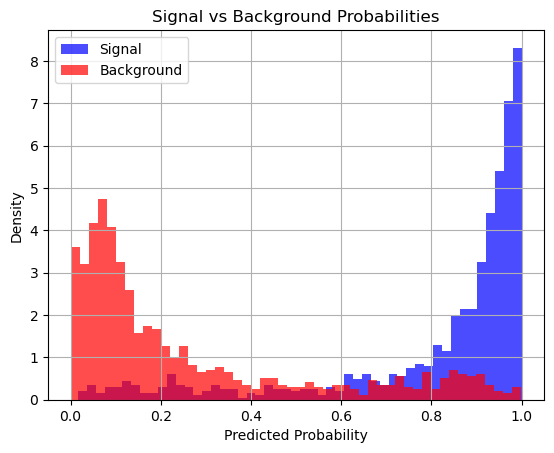


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 12] Train Loss: 0.2806


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 13] Val Accuracy: 0.8403
Accuracy: 0.8390, Precision: 0.8316, Recall: 0.8562, F1: 0.8437, ROC AUC: 0.9170


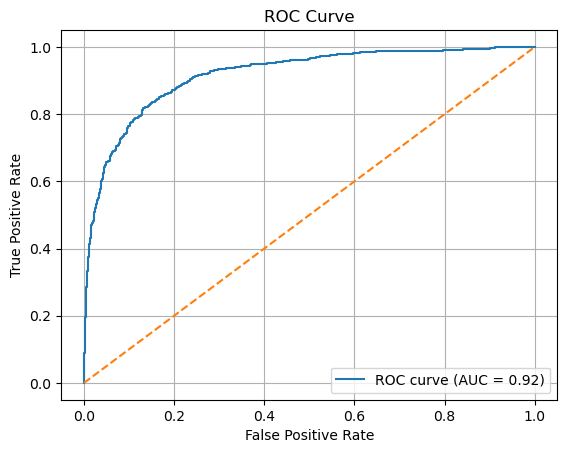

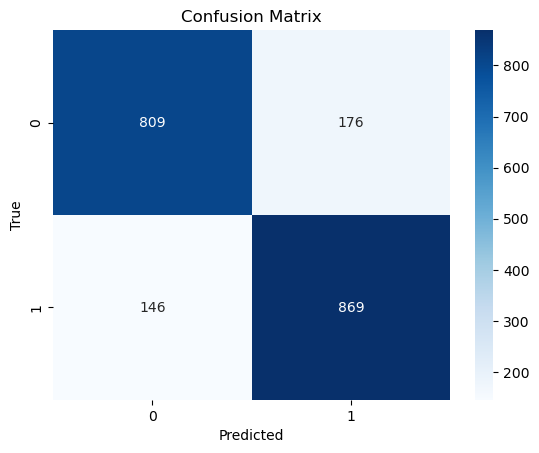

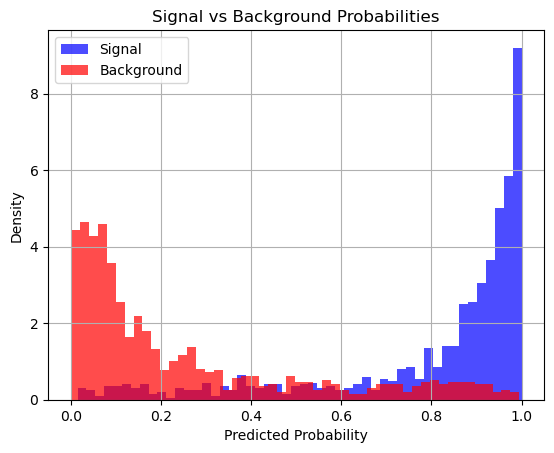


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 13] Train Loss: 0.2798


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 14] Val Accuracy: 0.8264
Accuracy: 0.8255, Precision: 0.7841, Recall: 0.9054, F1: 0.8404, ROC AUC: 0.9126


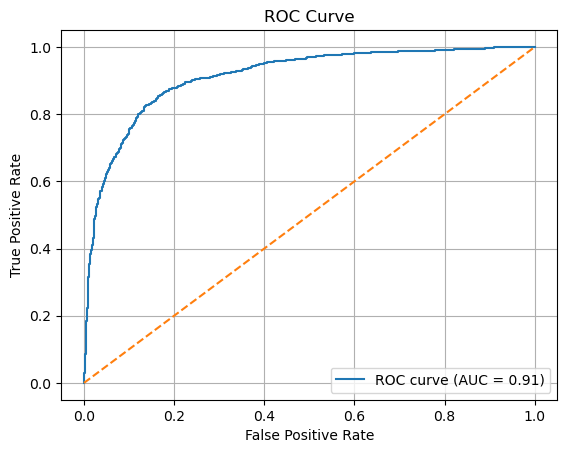

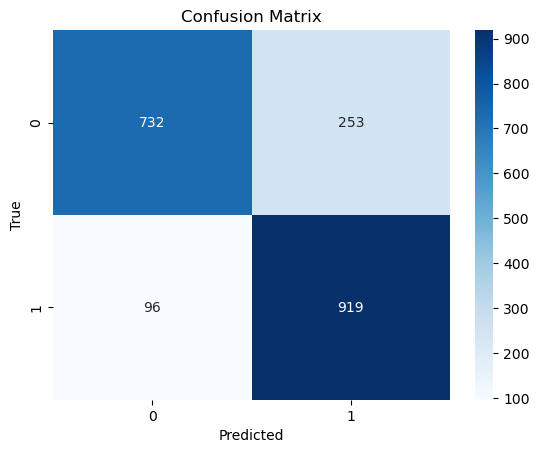

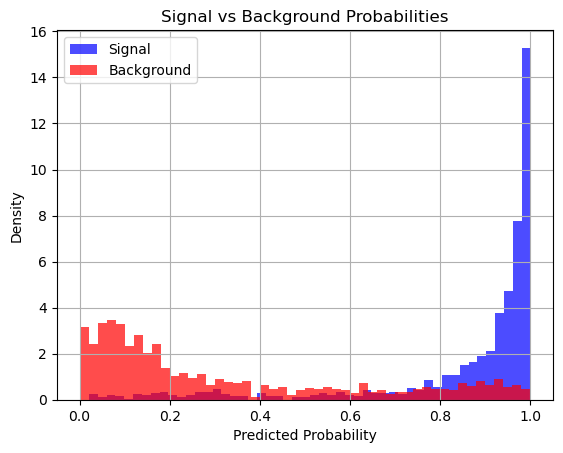


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 14] Train Loss: 0.2633


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 15] Val Accuracy: 0.8497
Accuracy: 0.8490, Precision: 0.8634, Recall: 0.8345, F1: 0.8487, ROC AUC: 0.9181


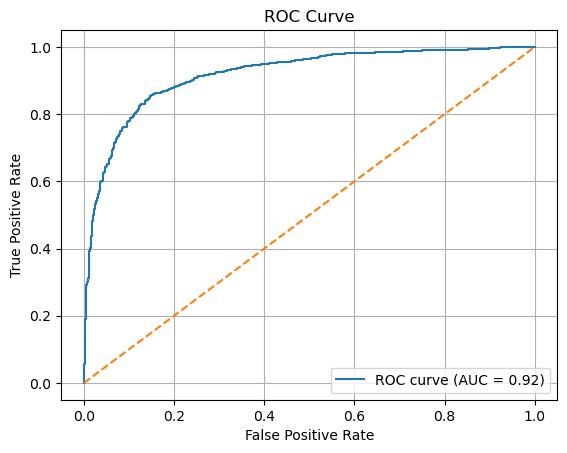

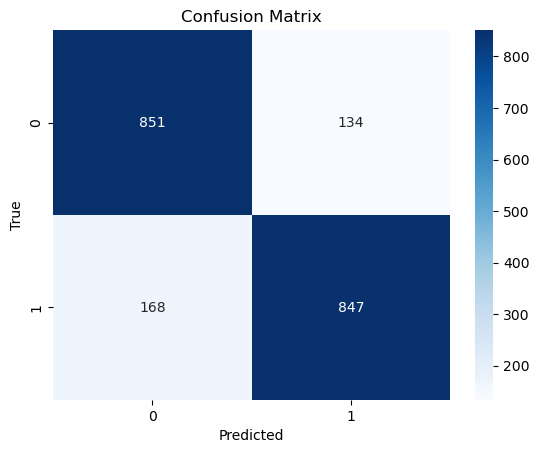

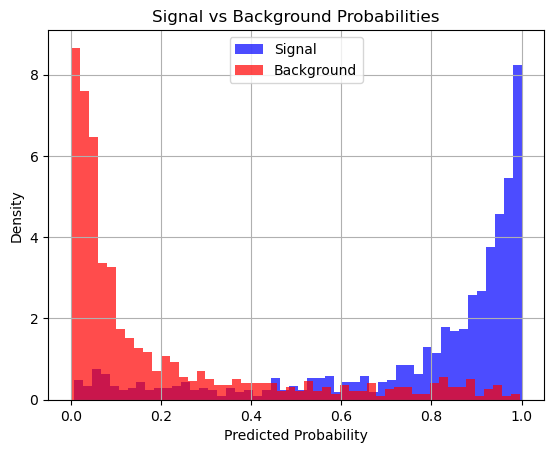


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 15] Train Loss: 0.1734


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 16] Val Accuracy: 0.7743
Accuracy: 0.7765, Precision: 0.9437, Recall: 0.5951, F1: 0.7299, ROC AUC: 0.9159


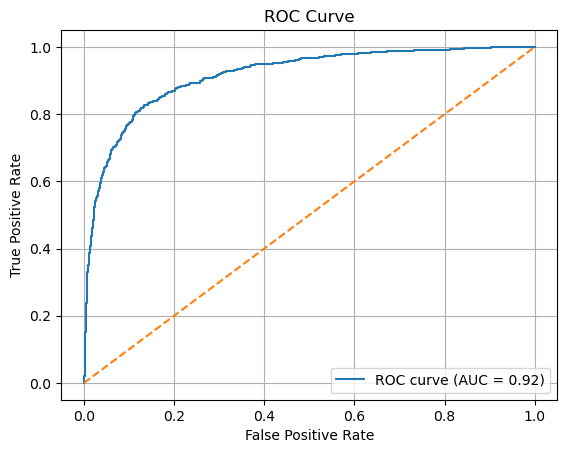

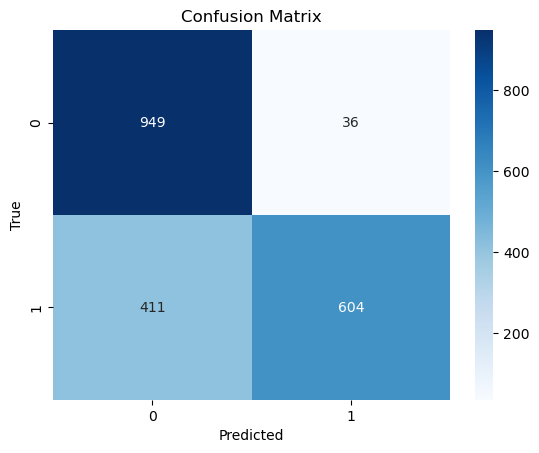

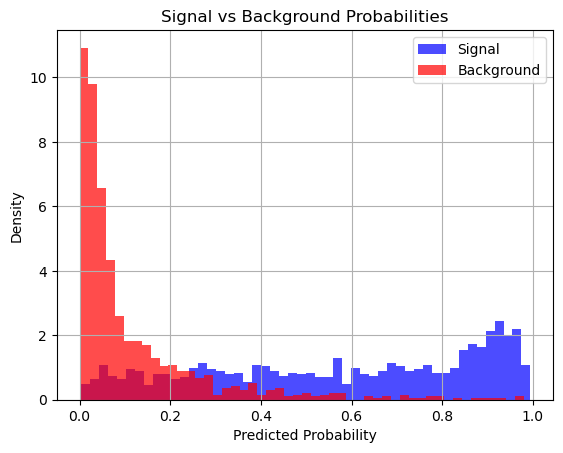


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 16] Train Loss: 0.1651


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 17] Val Accuracy: 0.8318
Accuracy: 0.8315, Precision: 0.8951, Recall: 0.7567, F1: 0.8201, ROC AUC: 0.9147


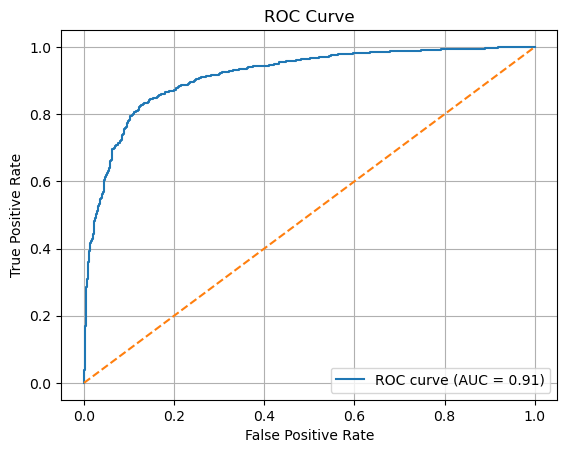

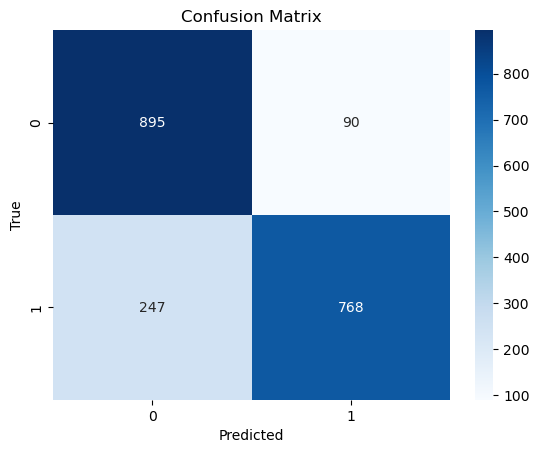

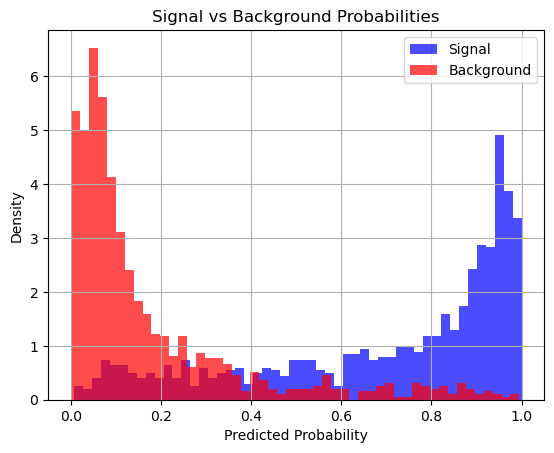


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 17] Train Loss: 0.0963


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 18] Val Accuracy: 0.8438
Accuracy: 0.8435, Precision: 0.8324, Recall: 0.8660, F1: 0.8489, ROC AUC: 0.9180


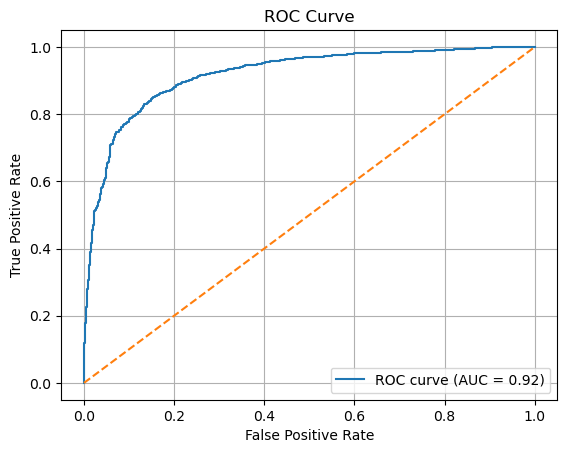

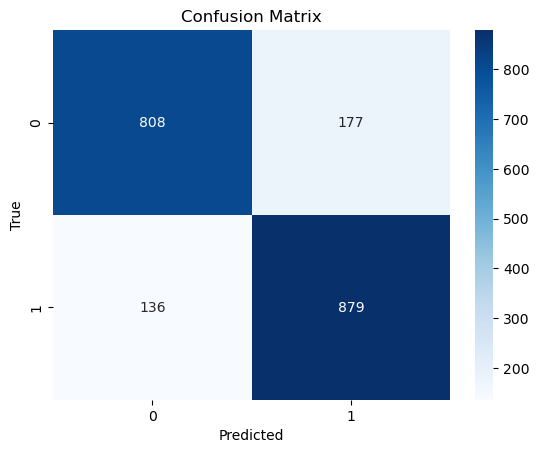

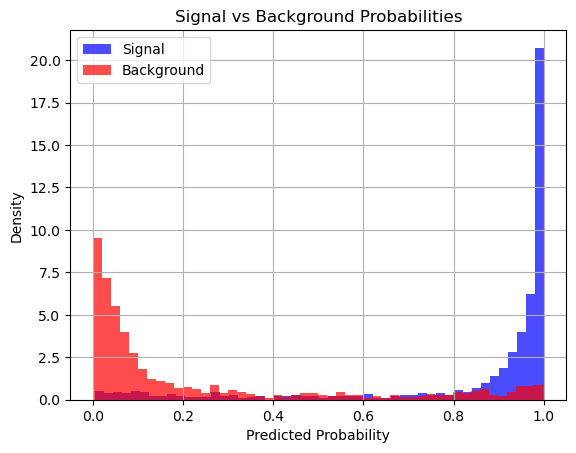


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 18] Train Loss: 0.1592


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 19] Val Accuracy: 0.8442
Accuracy: 0.8430, Precision: 0.8839, Recall: 0.7951, F1: 0.8371, ROC AUC: 0.9189


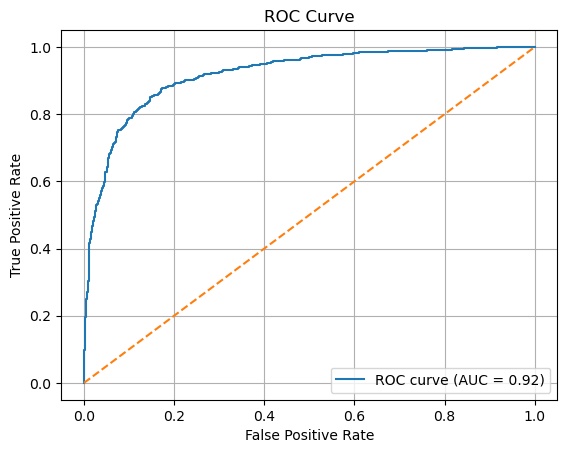

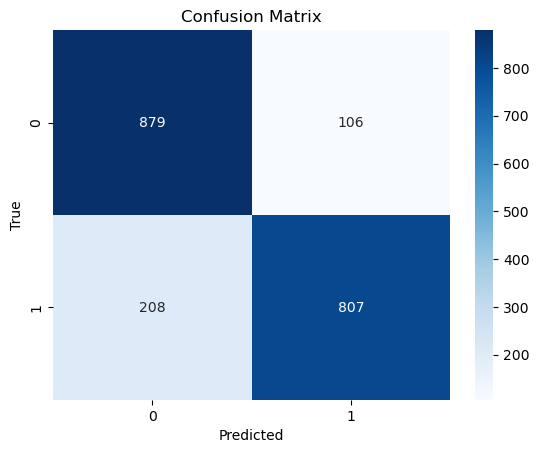

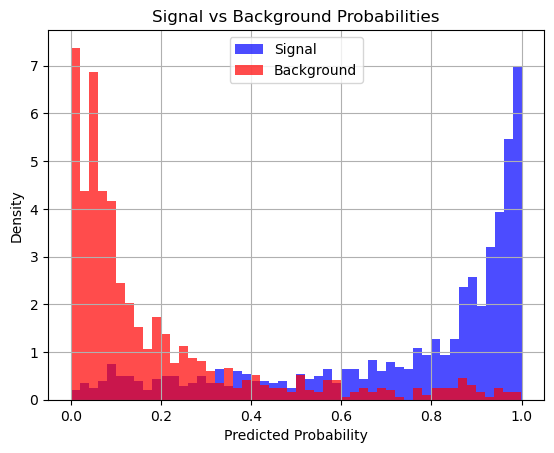


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 19] Train Loss: 0.2520


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 20] Val Accuracy: 0.8338
Accuracy: 0.8345, Precision: 0.9014, Recall: 0.7567, F1: 0.8227, ROC AUC: 0.9188


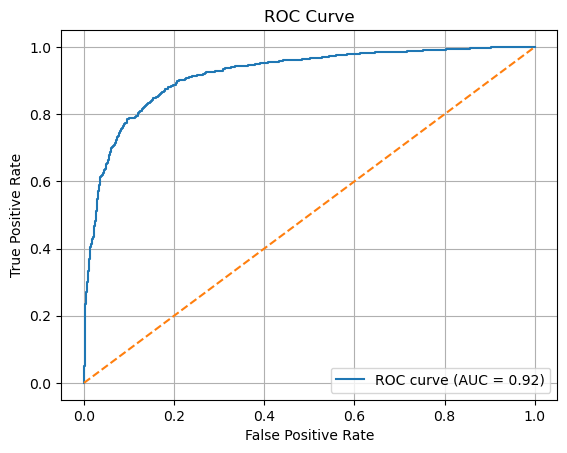

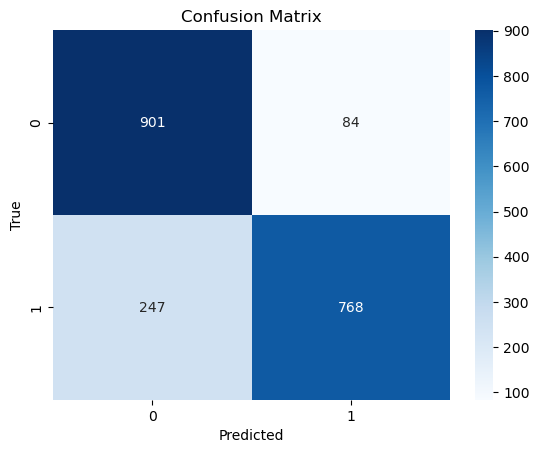

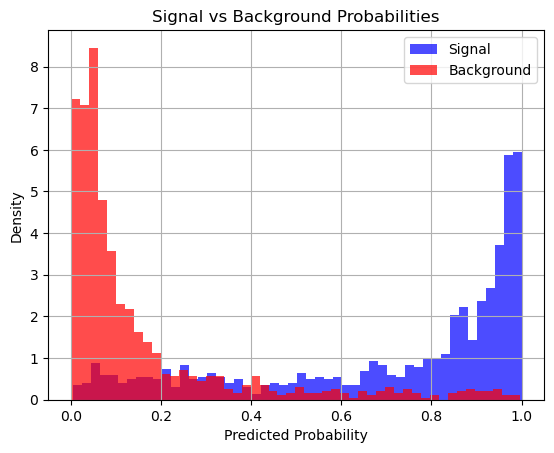


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 20] Train Loss: 0.1222


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 21] Val Accuracy: 0.8492
Accuracy: 0.8480, Precision: 0.8344, Recall: 0.8739, F1: 0.8537, ROC AUC: 0.9215


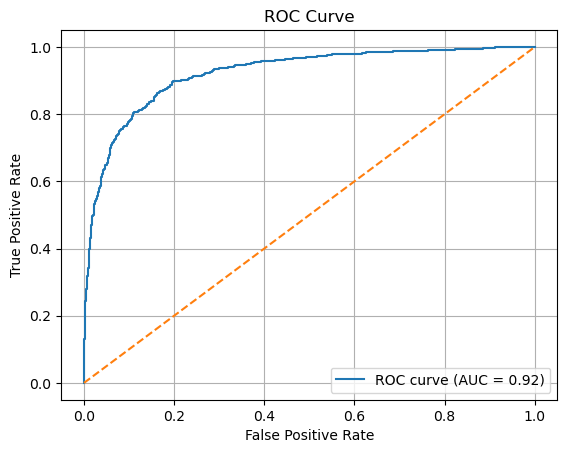

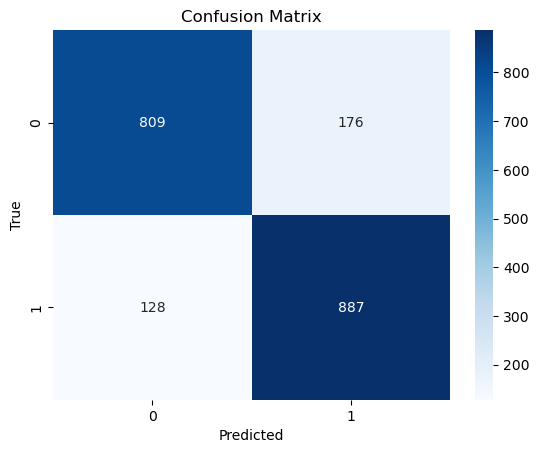

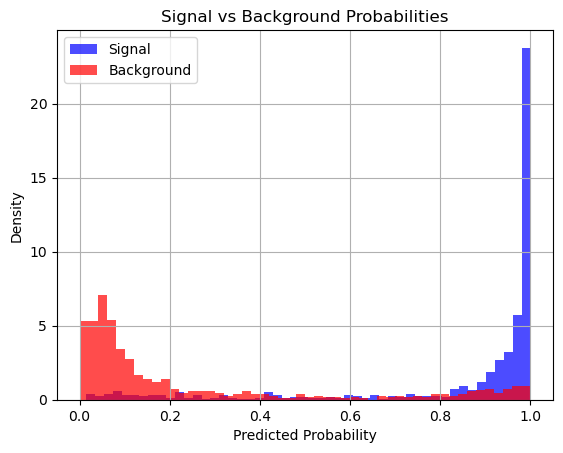


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 21] Train Loss: 0.1182


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 22] Val Accuracy: 0.8487
Accuracy: 0.8480, Precision: 0.8283, Recall: 0.8837, F1: 0.8551, ROC AUC: 0.9235


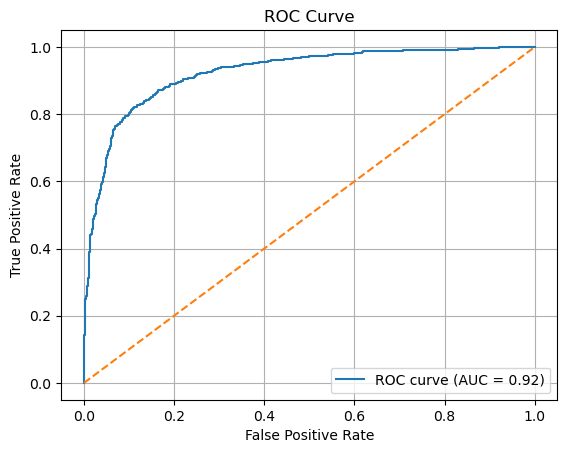

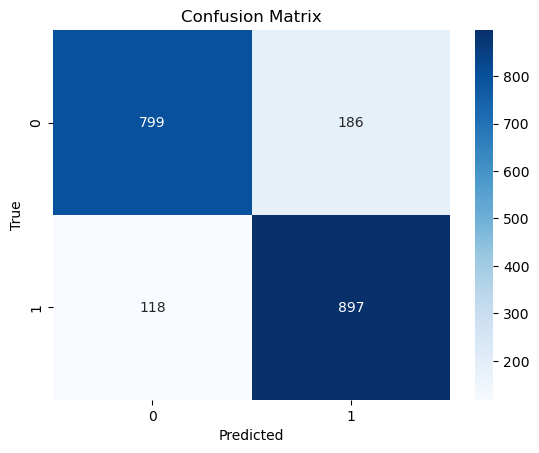

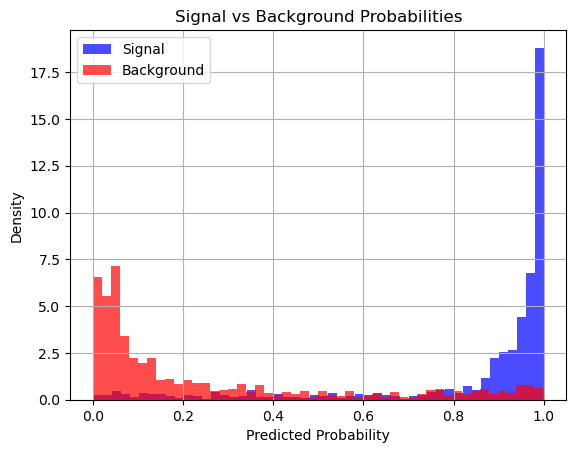


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 22] Train Loss: 0.0750


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 23] Val Accuracy: 0.8527
Accuracy: 0.8515, Precision: 0.8919, Recall: 0.8049, F1: 0.8462, ROC AUC: 0.9241


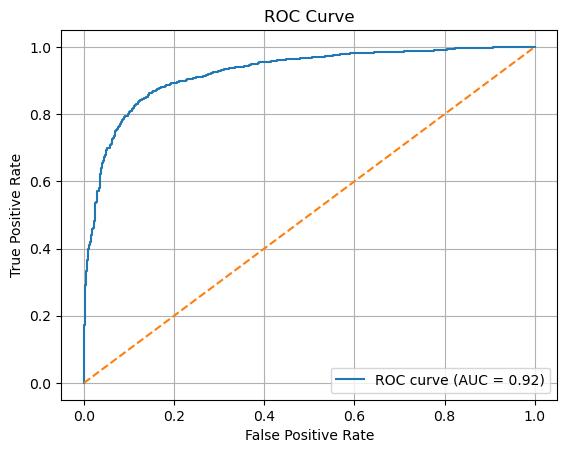

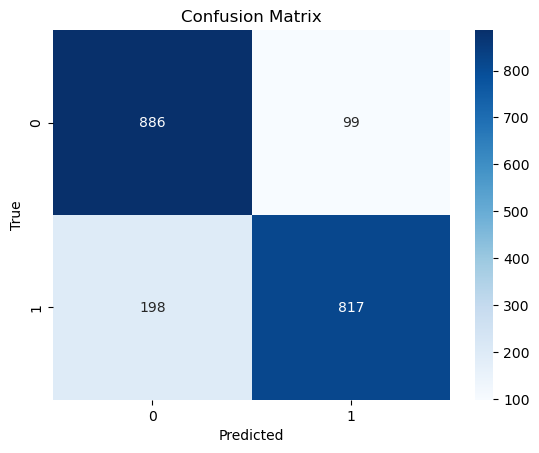

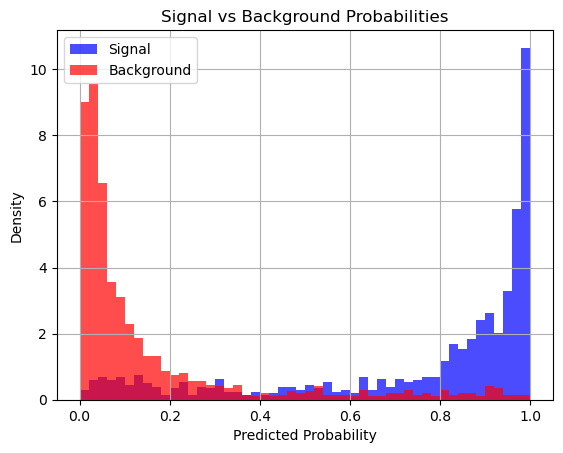


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 23] Train Loss: 0.1345


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 24] Val Accuracy: 0.8532
Accuracy: 0.8525, Precision: 0.8495, Recall: 0.8621, F1: 0.8557, ROC AUC: 0.9193


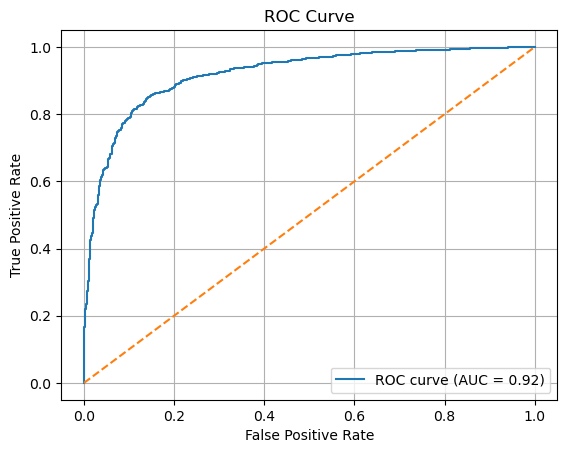

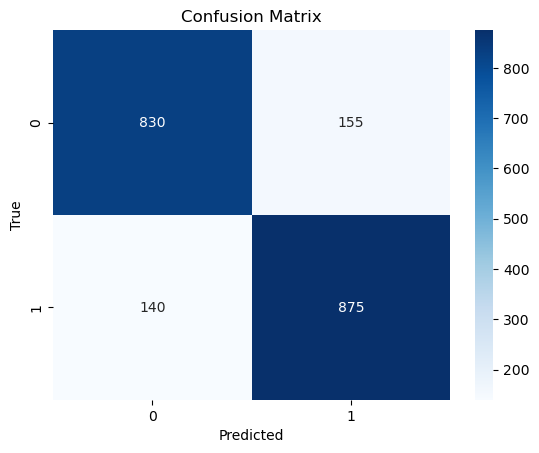

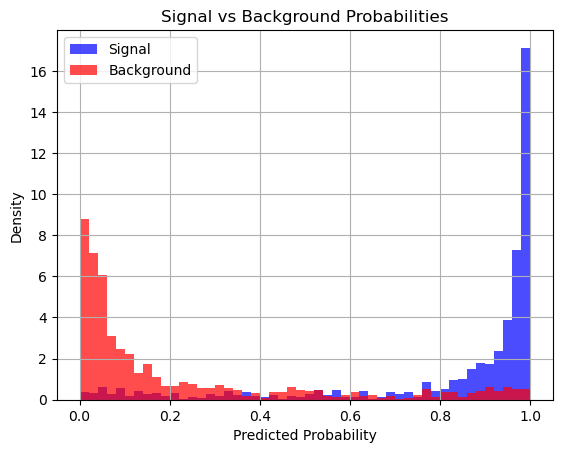


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 24] Train Loss: 0.1909


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 25] Val Accuracy: 0.8338
Accuracy: 0.8335, Precision: 0.9099, Recall: 0.7458, F1: 0.8197, ROC AUC: 0.9204


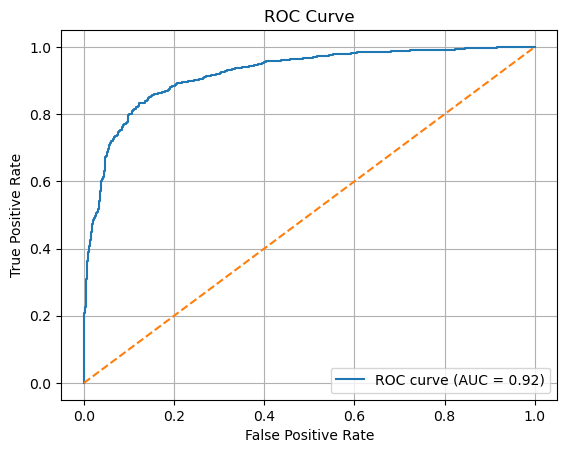

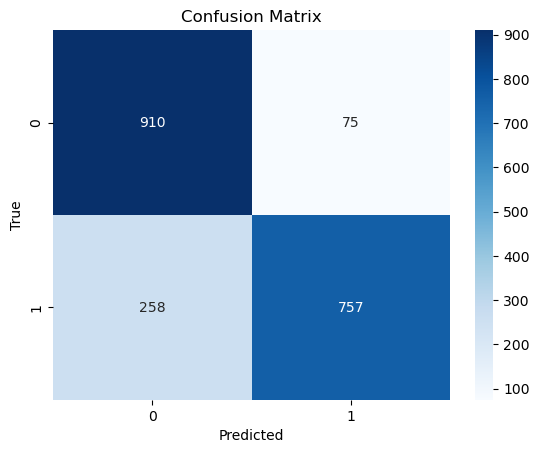

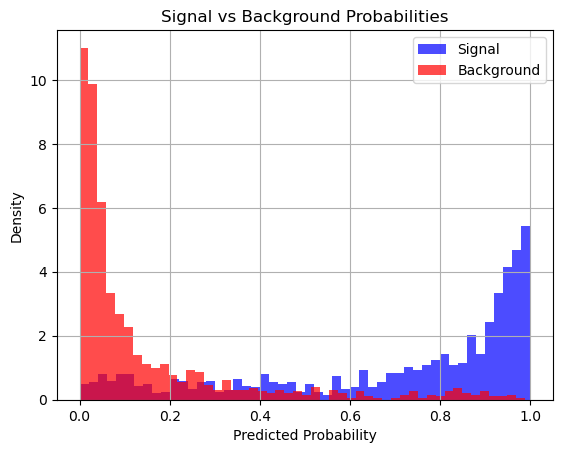


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 25] Train Loss: 0.1512


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 26] Val Accuracy: 0.8462
Accuracy: 0.8455, Precision: 0.8677, Recall: 0.8207, F1: 0.8435, ROC AUC: 0.9180


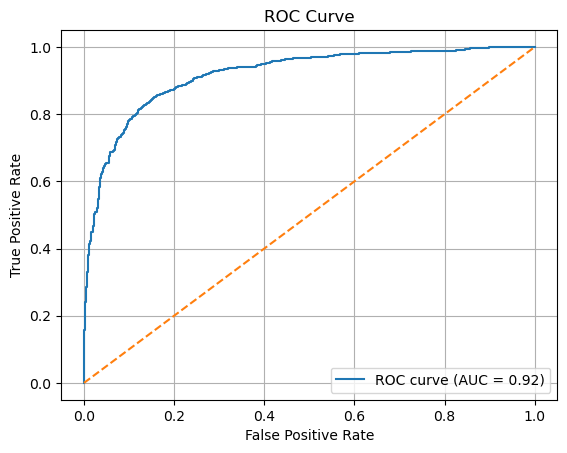

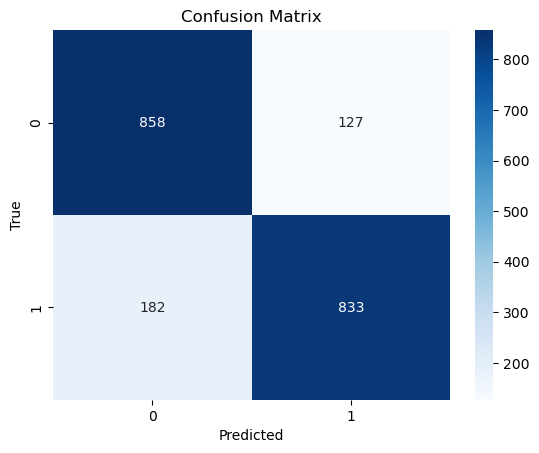

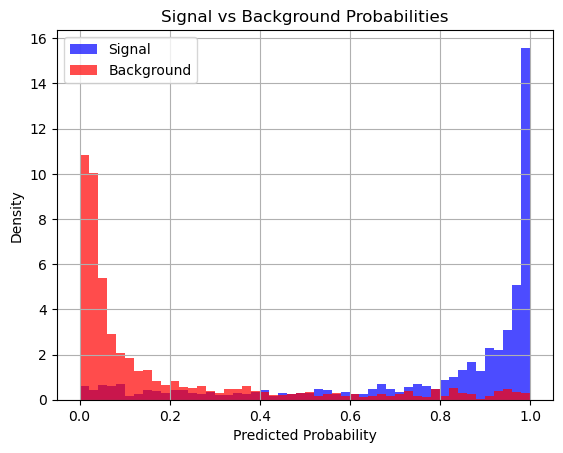


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 26] Train Loss: 0.1740


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 27] Val Accuracy: 0.8497
Accuracy: 0.8490, Precision: 0.8780, Recall: 0.8158, F1: 0.8458, ROC AUC: 0.9224


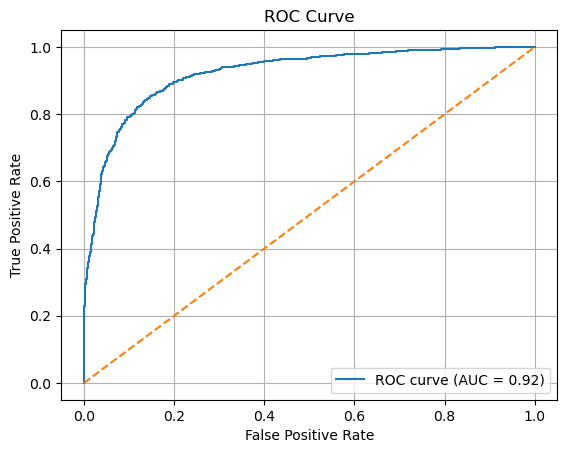

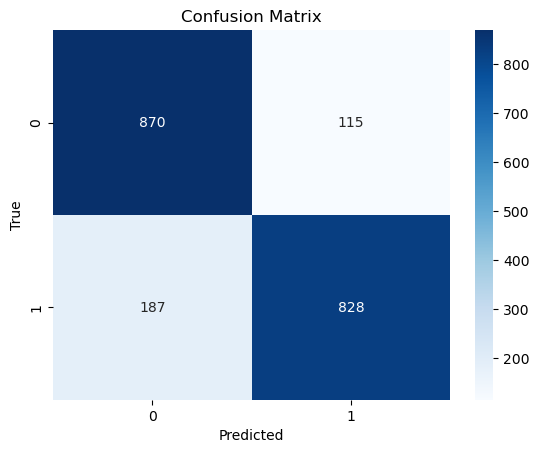

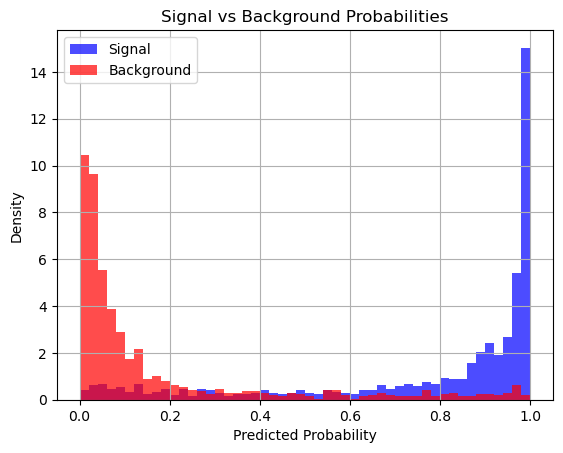


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 27] Train Loss: 0.0989


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 28] Val Accuracy: 0.8413
Accuracy: 0.8405, Precision: 0.8228, Recall: 0.8739, F1: 0.8476, ROC AUC: 0.9209


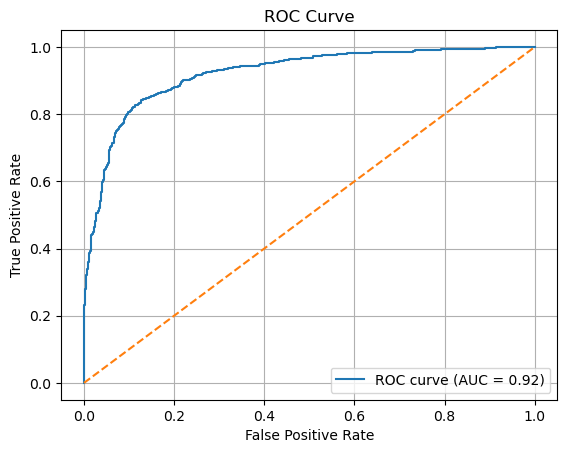

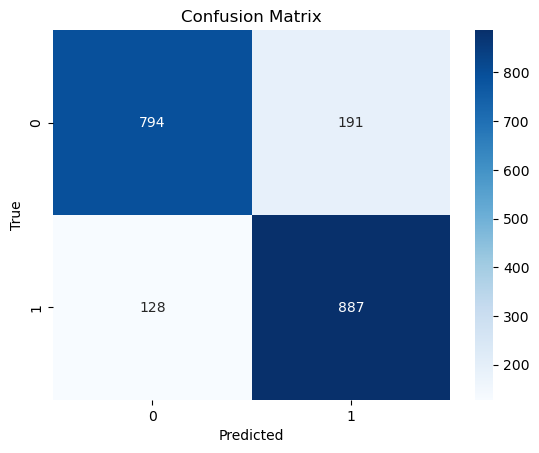

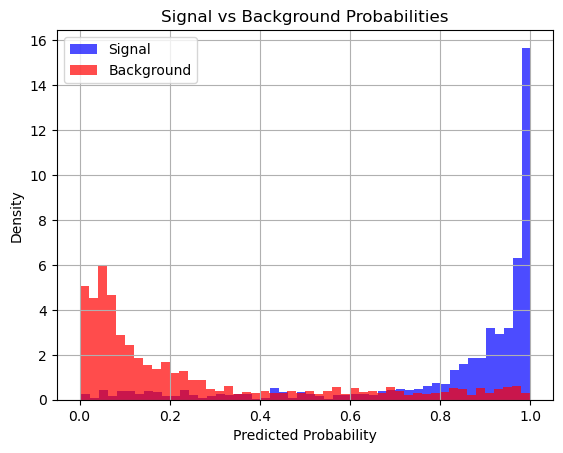


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 28] Train Loss: 0.1787


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 29] Val Accuracy: 0.8571
Accuracy: 0.8565, Precision: 0.8784, Recall: 0.8325, F1: 0.8548, ROC AUC: 0.9210


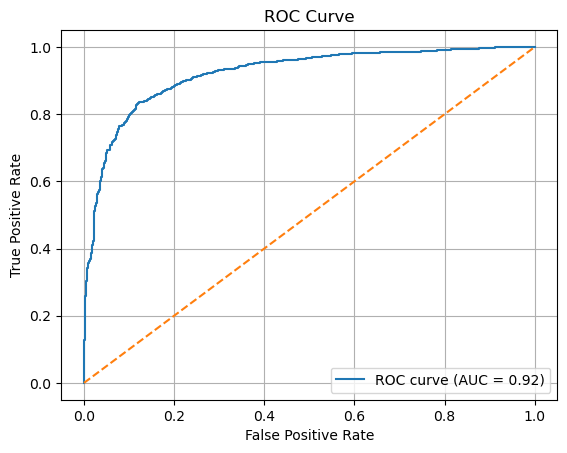

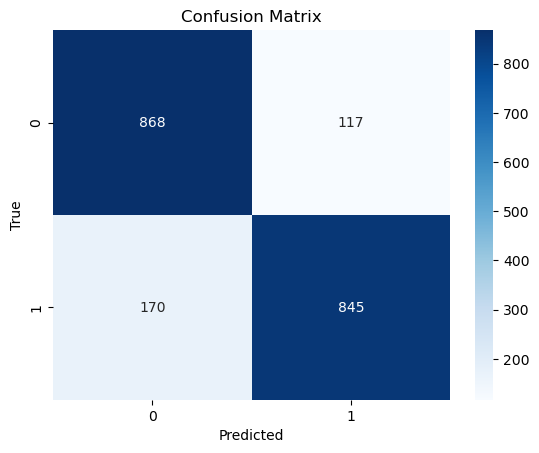

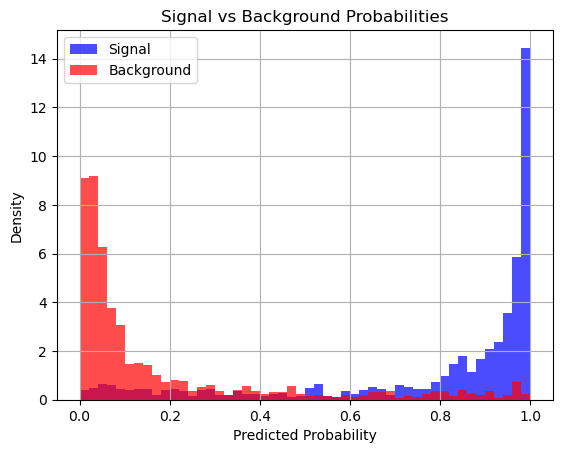


🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 29] Train Loss: 0.1168


Validation: |          | 0/? [00:00<?, ?it/s]

✅ [Epoch 30] Val Accuracy: 0.8428
Accuracy: 0.8425, Precision: 0.8968, Recall: 0.7793, F1: 0.8339, ROC AUC: 0.9218


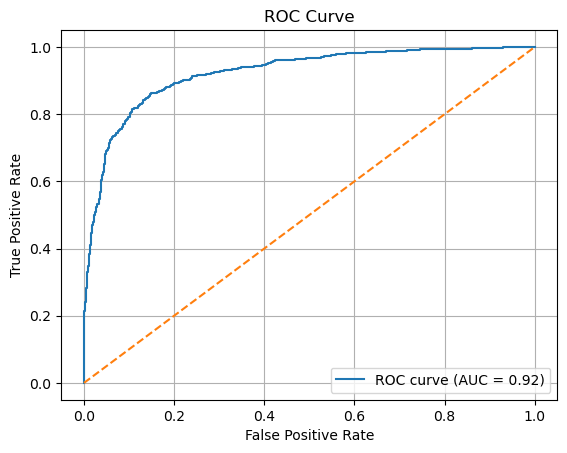

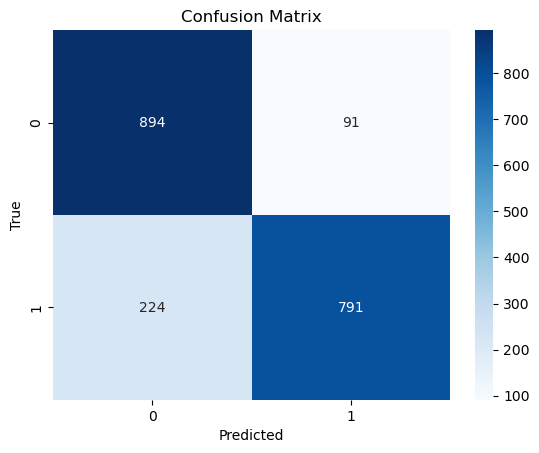

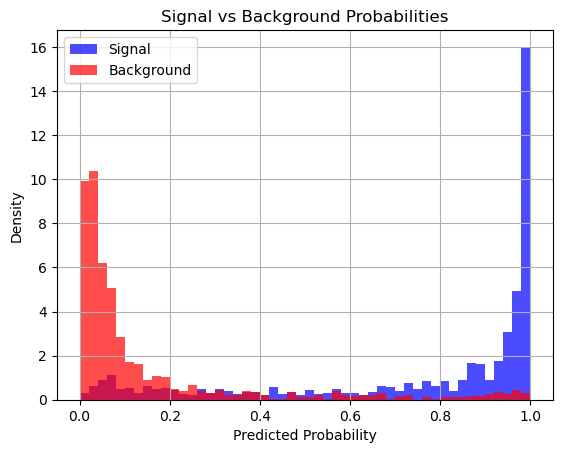

`Trainer.fit` stopped: `max_epochs=30` reached.



🎯 To view training progress, open a terminal and run:
   tensorboard --logdir tb_logs
Then visit http://localhost:6006 in your browser.
📉 [Epoch 30] Train Loss: 0.1482


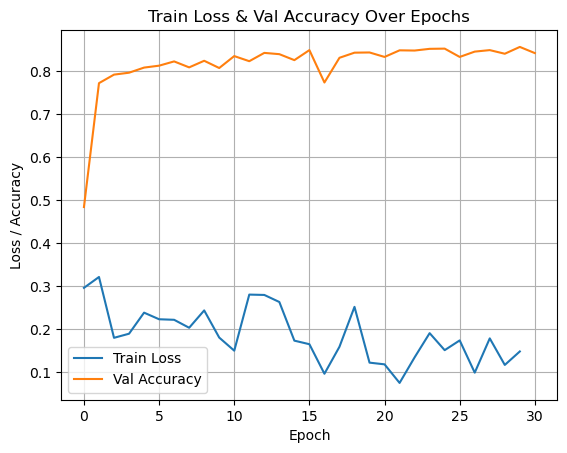

In [5]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import uproot
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.loggers import TensorBoardLogger
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from HyPER.models import MPNNs, HyperedgeModel, HyperedgeLoss, EdgeLoss, CombinedLoss
from torchmetrics.classification import BinaryAccuracy
import seaborn as sns
import joblib
import os
os.makedirs("results", exist_ok=True)

# Configuration
jet_features = ['Jet.PT', 'Jet.Phi', 'Jet.Mass', 'Jet.NCharged', 'Jet.EhadOverEem',
                'Jet.Eta', 'Jet.BTag', 'Jet.Flavor', 'Jet.T', 'Jet.DeltaEta',
                'Jet.DeltaPhi', 'Jet.ChargedEnergyFraction', 'Jet.NeutralEnergyFraction']
lepton_features = ['Electron.PT', 'Electron.Eta', 'Electron.Phi', 'Muon.PT', 'Muon.Eta', 'Muon.Phi']
met_features = ['MissingET.MET', 'MissingET.Phi']
all_features = jet_features + lepton_features + met_features

signal_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_signal_5k.root'
background_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_BKG_5k.root'
tree_name = 'Delphes'
batch_size = 32
delta_r_threshold = 2

# Helper functions
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(delta_eta**2 + delta_phi**2)

def normalize_features(x):
    if x.shape[0] == 0:
        return x
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)

def convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_thresh=2.0):
    N = x_all.shape[0]
    if N == 0:
        return None

    edge_index_list = []
    edge_attr_list = []
    edge_target_list = []
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            dr = delta_r(eta_all[i], phi_all[i], eta_all[j], phi_all[j])
            edge_index_list.append([i, j])
            edge_attr_list.append([dr])
            edge_target_list.append([1 if dr < delta_r_thresh else 0])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).T
    edge_attr_s = torch.tensor(edge_attr_list, dtype=torch.float)
    edge_attr_t = torch.tensor(edge_target_list, dtype=torch.float)

    hyperedge_list = []
    for j in range(N):
        neighbors = [j]
        for k in range(N):
            if j != k and delta_r(eta_all[j], phi_all[j], eta_all[k], phi_all[k]) < delta_r_thresh:
                neighbors.append(k)
        if len(neighbors) > 1:
            hyperedge_list.append(neighbors)

    if not hyperedge_list:
        return None

    node_indices = np.concatenate(hyperedge_list).astype(np.int64)
    hyperedge_indices = np.repeat(np.arange(len(hyperedge_list)), [len(h) for h in hyperedge_list]).astype(np.int64)
    hyperedge_index = torch.from_numpy(np.stack([node_indices, hyperedge_indices])).long()

    u_s = torch.tensor([[x_all[:, 0].sum(), x_all[:, 1].mean()]], dtype=torch.float)

    data = Data(
        x_s=torch.tensor(x_all, dtype=torch.float),
        u_s=u_s,
        edge_index=edge_index,
        edge_attr_s=edge_attr_s,
        edge_attr_s_batch=torch.zeros(edge_index.shape[1], dtype=torch.long),
        edge_attr_t=edge_attr_t.view(-1, 1),
        edge_index_h=hyperedge_index,
        edge_index_h_batch=torch.zeros(hyperedge_index.shape[1], dtype=torch.long),
        x_t=torch.tensor([label], dtype=torch.float),
        batch=torch.zeros(N, dtype=torch.long)
    )
    return data

def load_data_hyper_format(file_path, label):
    file = uproot.open(file_path)
    tree = file[tree_name]
    events = tree.arrays(all_features, library='np')
    data_list = []

    num_events = len(events[jet_features[0]])
    for i in range(num_events):
        jet_data = [events[feat][i] for feat in jet_features]
        x_jets = np.column_stack(jet_data)
        x_jets = np.nan_to_num(x_jets)
        x_jets = normalize_features(x_jets)

        elec_data = [events[feat][i] for feat in lepton_features[:3]]
        muon_data = [events[feat][i] for feat in lepton_features[3:]]
        x_elec = np.column_stack(elec_data) if len(elec_data[0]) > 0 else np.empty((0, 3))
        x_muon = np.column_stack(muon_data) if len(muon_data[0]) > 0 else np.empty((0, 3))
        x_leptons = np.vstack([x_elec, x_muon])

        if x_leptons.size == 0:
            x_leptons = np.zeros((0, 13))
        elif x_leptons.shape[1] != 13:
            x_leptons = np.pad(x_leptons, ((0, 0), (0, 13 - x_leptons.shape[1])), mode='constant')
        x_leptons = normalize_features(x_leptons)

        met_data = [events[feat][i] for feat in met_features]
        x_met = np.array(met_data).reshape(1, -1)
        x_met = np.nan_to_num(x_met)
        if x_met.shape[1] != 13:
            x_met = np.pad(x_met, ((0, 0), (0, 13 - x_met.shape[1])), mode='constant')
        x_met = normalize_features(x_met)

        x_all = np.vstack([x_jets, x_leptons, x_met])
        eta_all = np.concatenate([
            x_jets[:, 5] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 1] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 1] if x_met.shape[0] > 0 else np.array([])
        ])
        phi_all = np.concatenate([
            x_jets[:, 1] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 2] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 0] if x_met.shape[0] > 0 else np.array([])
        ])

        data = convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_threshold)
        if data:
            data_list.append(data)

    return data_list

# Load full dataset
signal_data = load_data_hyper_format(signal_file, 1)
background_data = load_data_hyper_format(background_file, 0)
dataset = signal_data + background_data
np.random.shuffle(dataset)
split = int(0.8 * len(dataset))
train_data = dataset[:split]
test_data = dataset[split:]
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

# TensorBoard logger
logger = TensorBoardLogger("lightning_logs", name="hypergraph")

# Define LightningModule
class LossHistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        loss = trainer.callback_metrics.get("train_loss")
        if loss is not None:
            train_loss = loss.cpu().item()
            self.train_losses.append(train_loss)
            print(f"📉 [Epoch {trainer.current_epoch+1}] Train Loss: {train_loss:.4f}")

    def on_validation_epoch_end(self, trainer, pl_module):
        val_metric = trainer.callback_metrics.get("val_acc_hyper")
        if val_metric is not None:
            val = val_metric.cpu().item()
            self.val_losses.append(val)
            print(f"✅ [Epoch {trainer.current_epoch+1}] Val Accuracy: {val:.4f}")

    def on_fit_end(self, trainer, pl_module):
        # Plot and save loss + val curves
        plt.figure()
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.val_losses, label="Val Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Loss / Accuracy")
        plt.title("Train Loss & Val Accuracy Over Epochs")
        plt.legend()
        plt.grid()
        plt.savefig("results/loss_curves.png")
        plt.savefig("results/loss_curves.pdf")
        plt.show()

class HyPERModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MPNNs(
            node_in_channels=13,
            edge_in_channels=1,
            global_in_channels=2,
            node_out_channels=32,
            edge_out_channels=1,
            global_out_channels=32,
            message_feats=32,
            dropout=0.01,
            activation=Sigmoid(),
            p_out='edge'
        )
        self.hyper = HyperedgeModel(
            node_in_channels=32,
            node_out_channels=1,
            global_in_channels=32,
            message_feats=32,
            dropout=0.01
        )
        self.criterion_edge = BCELoss(reduction='none')
        self.criterion_hyper = BCELoss()
        self.alpha = 0.5
        self.y_true, self.y_score = [], []

    def forward(self, data):
        x, edge_attr, u = self.model(
            data.x_s, data.edge_index, data.edge_attr_s, data.u_s, data.batch
        )
        x_hat, batch_hyper = self.hyper(
            x, u, data.batch, data.edge_index_h, data.edge_index_h_batch, 3
        )
        return x_hat, batch_hyper, edge_attr

    def training_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)
        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        loss_hyper = self.criterion_hyper(
            x_event_pred.view(-1), batch.x_t.float().view(-1)
        )
        loss_edge = EdgeLoss(
            edge_attr_prime.view(-1),
            batch.edge_attr_t.view(-1),
            batch.edge_attr_s_batch,
            self.criterion_edge,
            reduction='mean'
        )
        loss = CombinedLoss(loss_edge, loss_hyper, self.alpha, 'mean')
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)
        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        pred_probs = x_event_pred.detach().cpu().numpy()
        true_labels = batch.x_t.detach().cpu().numpy()
        self.y_score.extend(pred_probs)
        self.y_true.extend(true_labels)

        pred_class = (x_event_pred > 0.5).float()
        acc = (pred_class == batch.x_t.float()).float().mean()
        self.log('val_acc_hyper', acc, prog_bar=True)

    def on_validation_epoch_end(self):
        y_true = np.array(self.y_true)
        y_pred = np.array(self.y_score)
        y_pred_class = (y_pred > 0.5).astype(int)

        acc = accuracy_score(y_true, y_pred_class)
        prec = precision_score(y_true, y_pred_class)
        rec = recall_score(y_true, y_pred_class)
        f1 = f1_score(y_true, y_pred_class)
        roc = roc_auc_score(y_true, y_pred)

        self.log('val_roc_auc', roc, prog_bar=True, on_epoch=True)
        self.log('val_f1', f1, prog_bar=False, on_epoch=True)
        self.log('val_precision', prec, prog_bar=False, on_epoch=True)
        self.log('val_recall', rec, prog_bar=False, on_epoch=True)

        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC AUC: {roc:.4f}")

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid()
        plt.savefig("results/roc_curve.png")
        plt.savefig("results/roc_curve.pdf")
        plt.show()

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred_class)
        plt.figure()
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.grid(False)
        plt.savefig("results/confusion_matrix.png")
        plt.savefig("results/confusion_matrix.pdf")
        plt.show()

        # Histogram
        plt.figure()
        plt.hist(y_pred[y_true == 1], bins=50, alpha=0.7, label='Signal', color='blue', density=True)
        plt.hist(y_pred[y_true == 0], bins=50, alpha=0.7, label='Background', color='red', density=True)
        plt.xlabel('Predicted Probability')
        plt.ylabel('Density')
        plt.title('Signal vs Background Probabilities')
        plt.legend()
        plt.grid()
        plt.savefig("results/probability_histogram.png")
        plt.savefig("results/probability_histogram.pdf")
        plt.show()

        # Save outputs
        joblib.dump((y_true, y_pred), 'results/hyper_model_output.pkl')
        torch.save(self.state_dict(), 'results/hyper_model.pt')

        print("\n🎯 To view training progress, open a terminal and run:")
        print("   tensorboard --logdir tb_logs")
        print("Then visit http://localhost:6006 in your browser.")

        self.y_true.clear()
        self.y_score.clear()

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=10)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "val_acc_hyper",
                "frequency": 1,
                "strict": True
            },
        }

# Training loop
model = HyPERModel()
loss_callback = LossHistoryCallback()
trainer = Trainer(max_epochs=30, accelerator='auto', logger=logger, callbacks=[loss_callback])
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)



In [3]:
import torch

# Save the trained model's state_dict
torch.save(model.state_dict(), "hyperGraph_model.pt")